## Load Modules

In [22]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import os
import time
from tqdm import tqdm
import pickle
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold

from sklearn import linear_model, ensemble, neighbors, tree, svm

#from sklearn.utils import all_estimators
#from sklearn.base import RegressorMixin

import xgboost
import lightgbm

import tensorflow as tf

# Data Prep

In [2]:
# Load Datasets for each of the 4 sites
EE=pd.read_csv('../../Data/California Wetlands Joined/EE.csv',index_col='datetime',parse_dates=True)
MB=pd.read_csv('../../Data/California Wetlands Joined/MB.csv',index_col='datetime',parse_dates=True)
SW=pd.read_csv('../../Data/California Wetlands Joined/SW.csv',index_col='datetime',parse_dates=True)
WP=pd.read_csv('../../Data/California Wetlands Joined/WP.csv',index_col='datetime',parse_dates=True)

In [3]:
#define feature set

elke_cols=['VPD','GCC','ustar','TA','WT','RNET','H_gf','er_Reichstein']
time_cols=['year','DOY','time']
f_e=elke_cols+time_cols+['wq_gf']
#for testing Elke's columns going to need to add in 'wq_gf' and 'ze'

f_10=['DOY', 'GCC', 'H_gf', 'RH', 'RNET', 'TA', 'VPD', 'WT', 'cbar',
       'er_Reichstein', 'mbar', 'rho_mol_Met', 'stat_q', 'time', 'ubar',
       'ustar', 'uu', 'uw', 'vv', 'wq_gf', 'ww', 'year', 'ze']
f_25=['DOY', 'GCC', 'H_gf', 'PA_Met', 'RH', 'RNET', 'TA', 'TA_Met', 'TS_mean',
       'TW_mean', 'VPD', 'WD', 'WT', 'cbar', 'er_Reichstein', 'er_linear',
       'mbar', 'rho_mol_Met', 'sos', 'stat_m', 'stat_q', 'stat_wc', 'stat_wm',
       'stat_wt', 'tbar', 'time', 'tsbar', 'ubar', 'ustar', 'uu', 'uw', 'vv',
       'wm_gf', 'wq_gf', 'ww', 'year', 'ze']

#Variable present in more than one site
F_RFE=['DOY',
 'H_gf',
 'RH',
 'RNET',
 'TS_mean',
 'TW_mean',
 'VPD',
 'WD',
 'WT',
 'cbar',
 'er_linear',
 'tbar',
 'time',
 'ubar',
 'ustar',
 'uw',
 'wm_gf',
 'ww',
 'year',
 'ze',
 'wq_gf']

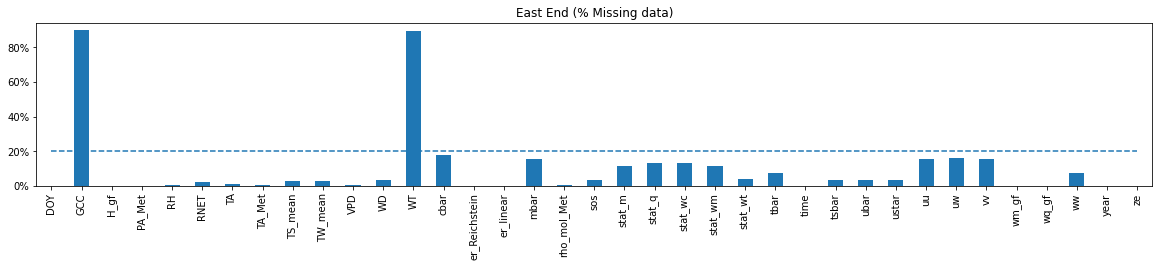

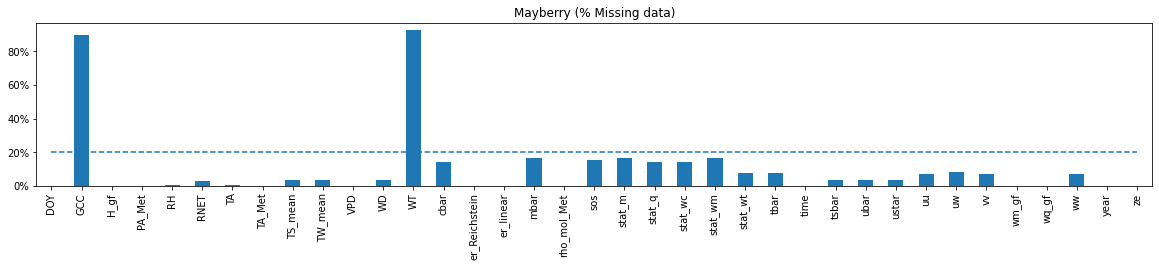

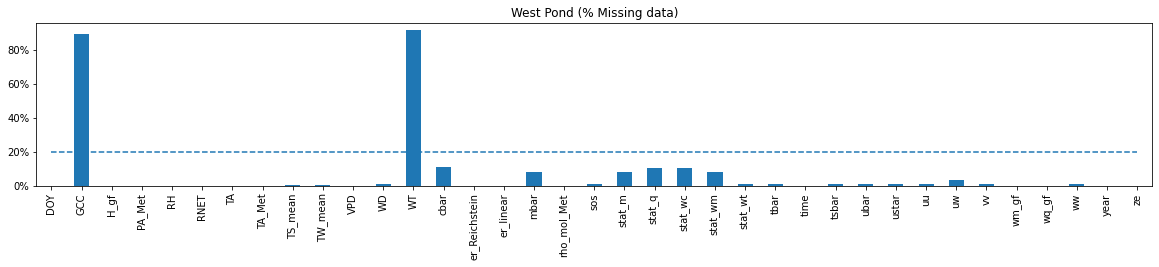

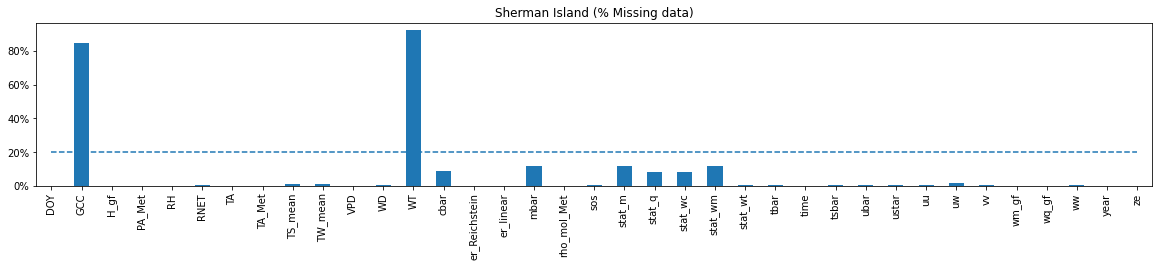

In [25]:
#Plot gaps in data

def gaps(df,title):
    ax=(100*df.isnull().sum()/len(df)).plot(kind='bar',figsize=(20,3),title=title)
    ax.hlines(20,ax.get_xticks().min(), ax.get_xticks().max(), linestyle='--')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.show()
    
gaps(EE[f_25],'East End (% Missing data)')
gaps(MB[f_25],'Mayberry (% Missing data)')
gaps(WP[f_25],'West Pond (% Missing data)')
gaps(SW[f_25],'Sherman Island (% Missing data)')

In [5]:
# Gap-filling

def impute(df):
    df_gf=df
    has_gaps=df_gf.isnull().sum()/len(df_gf)
    #What is this check actually doing?
    for col in has_gaps[has_gaps!=0].index:
        print(f'Filling gaps in {col}')
        df_gf.loc[:,col].fillna(df_gf[col].mean(),inplace=True)
    
    has_inf=df_gf.isin([np.inf, -np.inf]).sum()
    for col in has_inf[has_inf!=0].index:
        print(f'Replacing inf in {col}')
        col_mean=df_gf[col].mean()
        df_gf[col]=df_gf[col].replace(np.inf,col_mean)
    
    return df_gf

In [6]:
# Splitting into night, winter, flood

def data_split(DF_gf,flood_date_end=0,flood_date_start=0,drop_ze=False):
    night=DF_gf[DF_gf.ze>=90]
    
    winter=DF_gf[(DF_gf.ze<90) & ((DF_gf.index.month==12) | (DF_gf.index.month==1) | (DF_gf.index.month==2))]

    #There is no flooding period for WP
    if(flood_date_end):
        night=night[night.index>pd.to_datetime(flood_date_end)]
        winter=winter[winter.index>flood_date_end]
        
        #Flooding for SW started after the first date of measurement
        if(flood_date_start):
            flood=DF_gf[(DF_gf.index<flood_date_end) & (DF_gf.ze<90)]
        else:
            flood=DF_gf[(DF_gf.index<flood_date_end) & (DF_gf.ze<90)]
            
    else:
        flood=[]
    
    if drop_ze:
        return night.drop(columns=['ze']),test.drop(columns=['ze']),flood.drop(columns=['ze']),winter.drop(columns=['ze'])
                
    #Randomly shuffle the night set to avoid ordering bias
    night=night.sample(frac=1)    
        
    return night,winter,flood


#############################
#Check these dates with Elke
#############################

flood_date_EE='2014-05'
flood_date_MB='2011-04'

flood_date_SW_start='2016-11-06'
flood_date_SW_end='2017-04-22'

In [7]:
# Normalisation

def feature_scaler(features,time_cols,night,winter,flood=[]):
    night=night[features]
    winter=winter[features]
    #Flood gets brought in below    
    
    rscaler=RobustScaler()
    night_s=pd.DataFrame(data=rscaler.fit_transform(night.drop(columns=time_cols)),columns=night.columns.drop(time_cols),index=night.index)
    mmscaler=MinMaxScaler()
    night_s=night_s.join(pd.DataFrame(data=mmscaler.fit_transform(night[time_cols]),columns=time_cols,index=night.index))
    
    winter_s=pd.DataFrame(data=rscaler.transform(winter.drop(columns=time_cols)),columns=winter.columns.drop(time_cols),index=winter.index)
    winter_s=winter_s.join(pd.DataFrame(data=mmscaler.transform(winter[time_cols]),columns=time_cols,index=winter.index))
    
    if len(flood):
        flood=flood[features]
        flood_s=pd.DataFrame(data=rscaler.transform(flood.drop(columns=time_cols)),columns=flood.columns.drop(time_cols),index=flood.index)
        flood_s=flood_s.join(pd.DataFrame(data=mmscaler.transform(flood[time_cols]),columns=time_cols,index=flood.index))
    else:
        flood_s=[]
    
    return night_s, winter_s, flood_s

In [8]:
EE_n,EE_w,EE_f = data_split(impute(EE),flood_date_EE)
EE_n_s,EE_w_s,EE_f_s = feature_scaler(f_25,time_cols,EE_n,EE_w,EE_f)

Filling gaps in Mdate
Filling gaps in Mdate_mid
Filling gaps in decday
Filling gaps in year
Filling gaps in DOY
Filling gaps in time
Filling gaps in PA
Filling gaps in e_Kpa
Filling gaps in TA
Filling gaps in RH
Filling gaps in rhoa
Filling gaps in rhov
Filling gaps in rho
Filling gaps in rho_mol
Filling gaps in RNET
Filling gaps in G
Filling gaps in az
Filling gaps in ze
Filling gaps in WD
Filling gaps in alpha
Filling gaps in ubar
Filling gaps in wbar
Filling gaps in tbar
Filling gaps in uu
Filling gaps in vv
Filling gaps in ww
Filling gaps in uv
Filling gaps in uw
Filling gaps in vw
Filling gaps in ustar
Filling gaps in L
Filling gaps in qbar0
Filling gaps in qbar
Filling gaps in cbar
Filling gaps in mbar
Filling gaps in tt
Filling gaps in qq
Filling gaps in cc
Filling gaps in mm
Filling gaps in wt
Filling gaps in wts
Filling gaps in wq
Filling gaps in wc
Filling gaps in wm
Filling gaps in wq_bs
Filling gaps in wc_bs
Filling gaps in wt2
Filling gaps in wq2
Filling gaps in wc2
Fillin

In [9]:
MB_n,MB_w,MB_f = data_split(impute(MB),flood_date_MB)
MB_n_s,MB_w_s,MB_f_s = feature_scaler(f_25,time_cols,MB_n,MB_w,MB_f)

Filling gaps in Mdate
Filling gaps in Mdate_mid
Filling gaps in decday
Filling gaps in year
Filling gaps in DOY
Filling gaps in time
Filling gaps in PA
Filling gaps in e_Kpa
Filling gaps in TA
Filling gaps in RH
Filling gaps in rhoa
Filling gaps in rhov
Filling gaps in rho
Filling gaps in rho_mol
Filling gaps in RNET
Filling gaps in G
Filling gaps in az
Filling gaps in ze
Filling gaps in WD
Filling gaps in alpha
Filling gaps in ubar
Filling gaps in wbar
Filling gaps in tbar
Filling gaps in tsbar
Filling gaps in sos
Filling gaps in uu
Filling gaps in vv
Filling gaps in ww
Filling gaps in uv
Filling gaps in uw
Filling gaps in vw
Filling gaps in ustar
Filling gaps in L
Filling gaps in qbar
Filling gaps in cbar
Filling gaps in mbar
Filling gaps in tt
Filling gaps in qq
Filling gaps in cc
Filling gaps in mm
Filling gaps in wt
Filling gaps in wts
Filling gaps in wq
Filling gaps in wc
Filling gaps in wm
Filling gaps in wc0
Filling gaps in wq0
Filling gaps in wm0
Filling gaps in wq_bs
Filling 

In [10]:
SW_n,SW_w,SW_f = data_split(impute(SW),flood_date_SW_end,flood_date_SW_start)
SW_n_s,SW_w_s,SW_f_s = feature_scaler(f_25,time_cols,SW_n,SW_w,SW_f)

Filling gaps in Mdate
Filling gaps in Mdate_mid
Filling gaps in decday
Filling gaps in year
Filling gaps in DOY
Filling gaps in time
Filling gaps in PA
Filling gaps in e_Kpa
Filling gaps in TA
Filling gaps in RH
Filling gaps in rhoa
Filling gaps in rhov
Filling gaps in rho
Filling gaps in rho_mol
Filling gaps in RNET
Filling gaps in G
Filling gaps in az
Filling gaps in ze
Filling gaps in WD
Filling gaps in alpha
Filling gaps in ubar
Filling gaps in wbar
Filling gaps in tbar
Filling gaps in tsbar
Filling gaps in sos
Filling gaps in uu
Filling gaps in vv
Filling gaps in ww
Filling gaps in uv
Filling gaps in uw
Filling gaps in vw
Filling gaps in ustar
Filling gaps in L
Filling gaps in qbar
Filling gaps in cbar
Filling gaps in mbar
Filling gaps in tt
Filling gaps in qq
Filling gaps in cc
Filling gaps in mm
Filling gaps in wt
Filling gaps in wts
Filling gaps in wq
Filling gaps in wc
Filling gaps in wm
Filling gaps in wc0
Filling gaps in wq0
Filling gaps in wm0
Filling gaps in wq_bs
Filling 

In [11]:
WP_n,WP_w,WP_f = data_split(impute(WP))
WP_n_s,WP_w_s,WP_f_s = feature_scaler(f_25,time_cols,WP_n,WP_w)

Filling gaps in Mdate
Filling gaps in Mdate_mid
Filling gaps in decday
Filling gaps in year
Filling gaps in DOY
Filling gaps in time
Filling gaps in PA
Filling gaps in e_Kpa
Filling gaps in TA
Filling gaps in RH
Filling gaps in rhoa
Filling gaps in rhov
Filling gaps in rho
Filling gaps in rho_mol
Filling gaps in RNET
Filling gaps in G
Filling gaps in az
Filling gaps in ze
Filling gaps in WD
Filling gaps in alpha
Filling gaps in ubar
Filling gaps in wbar
Filling gaps in tbar
Filling gaps in tsbar
Filling gaps in sos
Filling gaps in uu
Filling gaps in vv
Filling gaps in ww
Filling gaps in uv
Filling gaps in uw
Filling gaps in vw
Filling gaps in ustar
Filling gaps in L
Filling gaps in qbar
Filling gaps in cbar
Filling gaps in mbar
Filling gaps in tt
Filling gaps in qq
Filling gaps in cc
Filling gaps in mm
Filling gaps in wt
Filling gaps in wts
Filling gaps in wq
Filling gaps in wc
Filling gaps in wm
Filling gaps in wc0
Filling gaps in wq0
Filling gaps in wm0
Filling gaps in wq_bs
Filling 

# Test range of base models

In [8]:
def adjusted_rsquared(r2, n, p):
    return 1 - ((1 - r2) * ((n - 1) / (n - p - 1)))

In [12]:
class GeneralRegressor:

    def __init__(
        self,
        verbose=0,
        ignore_warnings=True,
        custom_metric=None,
        random_state=42,
        regressors="all",
    ):
        self.verbose = verbose
        self.ignore_warnings = ignore_warnings
        self.custom_metric = custom_metric
        self.models = {}
        self.random_state = random_state
        
        #Important for choosing which regressors to use
        #Why do you need to make it a variable of the class?
        self.regressors = regressors

    def fit_test(self,  NIGHT, WINTER, FLOOD=[],REGRESSORS=[("Linear Regression",linear_model.LinearRegression)],
                 nsplits=2):
        """
        Returns
        -------
        scores : Pandas DataFrame
            Returns metrics of all the models in a Pandas DataFrame.
        predictions : Pandas DataFrame
            Returns predictions of all the models in a Pandas DataFrame.
        """
        R2 = []
        ADJR2 = []
        RMSE = []
        SLOPE=[]
        R2_W = []
        ADJR2_W = []
        RMSE_W = []
        SLOPE_W = []
        R2_F = []
        ADJR2_F = []
        RMSE_F = []
        SLOPE_F = []
        names = []
        MEAN_TIME = []
        SUM_TIME = []
        predictions = {}
    
        #Is this considering REGRESSORS to be a global variable? Why is self.regressors defined here and 
        #not in __init__ ?
        self.regressors = REGRESSORS
        
        #Set up the X and y sets for Night, Winter & Flood
        #print("Splitting into X and y")
        night_X=NIGHT.drop(columns=['wq_gf'])
        night_y=NIGHT.wq_gf
        winter_X=WINTER.drop(columns=['wq_gf'])
        winter_y=WINTER.wq_gf
        if(len(FLOOD)):
            flood_X=FLOOD.drop(columns=['wq_gf'])
            flood_y=FLOOD.wq_gf
            
        for name, model in self.regressors:
            
            temp_R2 = []
            temp_ADJR2 = []
            temp_RMSE = []
            temp_SLOPE=[]
            temp_R2_W = []
            temp_ADJR2_W = []
            temp_RMSE_W = []
            temp_SLOPE_W = []
            temp_R2_F = []
            temp_ADJR2_F = []
            temp_RMSE_F = []
            temp_SLOPE_F = []
            temp_TIME = []
            
            print(f"Testing {name}")
            names.append(name)

            #print(f"Entering k-fold cross-validation with {nsplits} splits")
            kf = KFold(n_splits=nsplits)
            for train_idx, test_idx in kf.split(NIGHT):
                start = time.time()
                
                pipe = Pipeline(steps=[("regressor", model())]) #Can also include preprocessing here
                #print("Fitting to night-time data")
                pipe.fit(night_X.iloc[train_idx], night_y.iloc[train_idx])

                #print("Testing")
                night_pred = pipe.predict(night_X.iloc[test_idx])
                winter_pred = pipe.predict(winter_X)

                #test scores
                #print("Getting scores")
                r_squared = r2_score(night_y.iloc[test_idx], night_pred)
                adj_rsquared = adjusted_rsquared(
                    r_squared, night_X.shape[0], night_X.shape[1]
                )
                rmse = np.sqrt(mean_squared_error(night_y.iloc[test_idx], night_pred))
                slope=np.polyfit(night_y.iloc[test_idx], night_pred,1)[0]

                #Could move this and include winter and flood scores
                if self.verbose:
                    scores_verbose = {
                        "Model": name,
                        "R-Squared": r_squared,
                        "Adjusted R-Squared": adj_rsquared,
                        "RMSE": rmse,
                        "Time taken": time.time() - start,
                        "Slope": slope
                    }

                    print(scores_verbose)

                #winter scores
                winter_r_squared = r2_score(winter_y, winter_pred)
                winter_adj_rsquared = adjusted_rsquared(
                    winter_r_squared, winter_X.shape[0], winter_X.shape[1]
                )
                winter_rmse = np.sqrt(mean_squared_error(winter_y, winter_pred))
                winter_slope=np.polyfit(winter_y, winter_pred,1)[0]

                #Store temporary results from this CV fold
                #print("Storing temporary results from cross-validation") #Would be useful to print fold number
                temp_R2.append(r_squared)
                temp_ADJR2.append(adj_rsquared)
                temp_RMSE.append(rmse)
                temp_SLOPE.append(slope)
                
                temp_R2_W.append(winter_r_squared)
                temp_ADJR2_W.append(winter_adj_rsquared)
                temp_RMSE_W.append(winter_rmse)
                temp_SLOPE_W.append(winter_slope)

                if(len(FLOOD)):
                    #print("Testing on Flood data")
                    flood_pred= pipe.predict(flood_X)
                    #flood scores
                    flood_r_squared = r2_score(flood_y, flood_pred)
                    flood_adj_rsquared = adjusted_rsquared(
                        flood_r_squared, flood_X.shape[0], flood_X.shape[1]
                    )
                    flood_rmse = np.sqrt(mean_squared_error(flood_y, flood_pred))
                    flood_slope=np.polyfit(flood_y, flood_pred,1)[0]
                    

                    #Add scores to temp list
                    temp_R2_F.append(flood_r_squared)
                    temp_ADJR2_F.append(flood_adj_rsquared)
                    temp_RMSE_F.append(flood_rmse)
                    temp_SLOPE_F.append(flood_slope)
                    
                temp_TIME.append(time.time() - start)

###################################################################################################################
                
                #Add in a check to see if the model performed better than previous versions, 
                #store just that model and its predictions (otherwise just the last model is saved)

                #Or could save all models with their fold number and then take the mean of the predictions
                #outside this indent

                #This stores the model
                #print("Storing model") #Say which model is being stored?
                self.models[name] = pipe 
                #This stores the predictions
                if self.predictions:
                    #print("Storing predictions") #Say which model the predictions are from?
                    predictions[name] = night_pred
                    #Could also store winter and flood predictions
                    #Could also store the mean prediction in the case of CV, 
                    #At the moment it will just store the last set of predictions
                    
###################################################################################################################

            #Store mean result from CV
            #print("Calculating mean metrics across all cross-validation folds")

            R2.append(np.mean(temp_R2))
            ADJR2.append(np.mean(temp_ADJR2))
            RMSE.append(np.mean(temp_RMSE))
            SLOPE.append(np.mean(temp_SLOPE))

            R2_W.append(np.mean(temp_R2_W))
            ADJR2_W.append(np.mean(temp_ADJR2_W))
            RMSE_W.append(np.mean(temp_RMSE_W))
            SLOPE_W.append(np.mean(temp_SLOPE_W))

            if(len(FLOOD)):
                R2_F.append(np.mean(temp_R2_F))
                ADJR2_F.append(np.mean(temp_ADJR2_F))
                RMSE_F.append(np.mean(temp_RMSE_F))
                SLOPE_F.append(np.mean(temp_SLOPE_F))
                
            MEAN_TIME.append(np.mean(temp_TIME))
            SUM_TIME.append(np.sum(temp_TIME))

            #Store std results from CV?

        
        scores = {
            "Model": names,
            "Adjusted R-Squared - Night": ADJR2,
            "R-Squared - Night": R2,
            "RMSE - Night": RMSE,
            "Slope - Night": SLOPE,
            "Adjusted R-Squared - Winter": ADJR2_W,
            "R-Squared - Winter": R2_W,
            "RMSE - Winter": RMSE_W,
            "Slope - Winter": SLOPE_W
        }
        
        if(len(FLOOD)):
            scores['Adjusted R-Squared - Flood']=ADJR2_F
            scores['R-Squared - Flood']=R2_F
            scores['RMSE - Flood']=RMSE_F
            scores["Slope - Flood"]=SLOPE_F
            
            
        scores["Time/fold"] = MEAN_TIME
        scores["Time (total)"] = SUM_TIME
        
        
        try:
            scores = pd.DataFrame(scores)
            scores = scores.sort_values(by="Adjusted R-Squared - Night", ascending=False).set_index("Model")
        except: 
            return scores


### Gotta test em all

In [60]:
REGRESSORS=[]

#Ensembles
REGRESSORS.append(("LGBMRegressor", lightgbm.LGBMRegressor))
REGRESSORS.append(("XGBRegressor", xgboost.XGBRegressor))
REGRESSORS.append(("GradientBoostingRegressor", ensemble.GradientBoostingRegressor))
#REGRESSORS.append(('CatBoostRegressor',catboost.CatBoostRegressor))
#REGRESSORS.append(("HistGradientBoostingRegressor", ensemble.HistGradientBoostingRegressor)) #slow

#Trees
REGRESSORS.append(("DecisionTreeRegressor", tree.DecisionTreeRegressor))

#Linear Models
REGRESSORS.append(("LinearRegression",linear_model.LinearRegression))
#REGRESSORS.append(("LAR",linear_model.Lars))
REGRESSORS.append(("Ridge",linear_model.Ridge))
#REGRESSORS.append(("LassoCV",linear_model.Ridge))

#Neighbors
REGRESSORS.append(("KNNRegressor",neighbors.KNeighborsRegressor))

#SVR
#REGRESSORS.append(('SVR',svm.SVR))

In [23]:
# Test all four sites, all three feature sets and the effect of normalisation

sites={'WP':[WP_n,WP_w],'EE':[EE_n,EE_w,EE_f],'MB':[MB_n,MB_w,MB_f],'SW':[SW_n,SW_w,SW_f]}
#sites_scaled={'EE':[EE_n_s,EE_w_s,EE_f_s],'MB':[MB_n_s,MB_w_s,MB_f_s],'SW':[SW_n_s,SW_w_s,SW_f_s],'WP':[WP_n_s,WP_w_s]}

feature_sets={'f_e':f_e,'f_25':f_25,'F_RFE':F_RFE}

SCORES={'EE':{},'MB':{},'SW':{},'WP':{}}
#SCORES_SCALED={'EE':[],'MB':[],'SW':[],'WP':[]}

#If restarting the process can load scores from previously saved pickle file instead
#with open('SCORES.pkl', 'rb') as f:
    #SCORES = pickle.load(f)
    

In [35]:
for site in sites:
    print(site)
    for fs_id in feature_sets:
        print(fs_id)
        Regressor = GeneralRegressor(verbose=False,predictions=False)
        night=sites[site][0][feature_sets[fs_id]]
        winter=sites[site][1][feature_sets[fs_id]]
        if (site=='WP'):
            flood=[]
        else:
            flood=sites[site][2][feature_sets[fs_id]]
        
        SCORES[site][fs_id]=Regressor.fit_test(night,winter,flood,REGRESSORS,nsplits=10)
    
    with open('SCORES.pkl', 'wb') as out_file:
        pickle.dump(SCORES, out_file)

WP
F_RFE_2
Testing LGBMRegressor
Testing XGBRegressor
Testing GradientBoostingRegressor
Testing DecisionTreeRegressor
Testing LAR
Testing LassoCV
Testing KNNRegressor
EE
F_RFE_2
Testing LGBMRegressor
Testing XGBRegressor
Testing GradientBoostingRegressor
Testing DecisionTreeRegressor
Testing LAR
Testing LassoCV
Testing KNNRegressor
MB
F_RFE_2
Testing LGBMRegressor
Testing XGBRegressor
Testing GradientBoostingRegressor
Testing DecisionTreeRegressor
Testing LAR
Testing LassoCV
Testing KNNRegressor
SW
F_RFE_2
Testing LGBMRegressor
Testing XGBRegressor
Testing GradientBoostingRegressor
Testing DecisionTreeRegressor
Testing LAR
Testing LassoCV
Testing KNNRegressor


### Reload scores

In [25]:
with open('SCORES.pkl', 'rb') as f:
    SCORES = pickle.load(f)

# Tabular Results

In [5]:
f_E_results=pd.read_csv("../../Data/Water Flux/California Wetlands Results/f_E_NN_Results_Elke.csv",index_col='Model')

In [12]:
EE_NN=f_E_results.loc[f_E_results['Site']=='EE']
EE_NN['Adjusted R-Squared - Night']=adjusted_rsquared(EE_NN['R-Squared - Night'],len(EE),len(f_e))
EE_NN['Adjusted R-Squared - Winter']=adjusted_rsquared(EE_NN['R-Squared - Winter'],len(EE),len(f_e))
EE_NN['Adjusted R-Squared - Flood']=adjusted_rsquared(EE_NN['R-Squared - Flood'],len(EE),len(f_e))

/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [13]:
MB_NN=f_E_results[f_E_results['Site']=='MB']
MB_NN['Adjusted R-Squared - Night']=adjusted_rsquared(MB_NN['R-Squared - Night'],len(MB),len(f_e))
MB_NN['Adjusted R-Squared - Winter']=adjusted_rsquared(MB_NN['R-Squared - Winter'],len(MB),len(f_e))
MB_NN['Adjusted R-Squared - Flood']=adjusted_rsquared(MB_NN['R-Squared - Flood'],len(MB),len(f_e))

/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [14]:
SW_NN=f_E_results[f_E_results['Site']=='SW']
SW_NN['Adjusted R-Squared - Night']=adjusted_rsquared(SW_NN['R-Squared - Night'],len(SW),len(f_e))
SW_NN['Adjusted R-Squared - Winter']=adjusted_rsquared(SW_NN['R-Squared - Winter'],len(SW),len(f_e))
SW_NN['Adjusted R-Squared - Flood']=adjusted_rsquared(SW_NN['R-Squared - Flood'],len(SW),len(f_e))

/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [15]:
WP_NN=f_E_results[f_E_results['Site']=='WP']
WP_NN['Adjusted R-Squared - Night']=adjusted_rsquared(WP_NN['R-Squared - Night'],len(WP),len(f_e))
WP_NN['Adjusted R-Squared - Winter']=adjusted_rsquared(WP_NN['R-Squared - Winter'],len(WP),len(f_e))

/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Plot Results

## EE Plotting

In [16]:
EE_fe=SCORES['EE']['f_e'][0]
EE_fe['Feature Set']='f_E'
EE_fe=EE_fe[~EE_fe.index.isin(['LAR','LassoCV'])]
EE_f25=SCORES['EE']['f_25'][0]
EE_f25['Feature Set']='f_25'
EE_f25=EE_f25[~EE_f25.index.isin(['LAR','LassoCV'])]
EE_fRFE=SCORES['EE']['F_RFE'][0]
EE_fRFE['Feature Set']='f_RFE'
EE_fRFE=EE_fRFE[~EE_fRFE.index.isin(['LAR','LassoCV'])]

ee=EE_fe.append(EE_f25).append(EE_fRFE).append(EE_NN).reset_index()

In [17]:
ee

,Model,Adjusted R-Squared - Night,R-Squared - Night,RMSE - Night,Slope - Night,Adjusted R-Squared - Winter,R-Squared - Winter,RMSE - Winter,Slope - Winter,Adjusted R-Squared - Flood,R-Squared - Flood,RMSE - Flood,Slope - Flood,Time/fold,Time (total),Feature Set,Site
0,XGBRegressor,0.94461,0.94463,0.17851,0.94234,-0.24790,-0.24664,0.74236,0.57940,0.60088,0.60216,0.83465,0.66391,2.28138,22.81383,f_E,NaN
1,LGBMRegressor,0.93707,0.93709,0.19017,0.92744,0.03222,0.03320,0.65584,0.58005,0.67159,0.67264,0.75826,0.67107,0.22188,2.21876,f_E,NaN
2,GradientBoostingRegressor,0.89876,0.89879,0.24143,0.87580,-0.10465,-0.10353,0.69926,0.53198,0.54112,0.54258,0.89579,0.51960,9.05317,90.53166,f_E,NaN
3,DecisionTreeRegressor,0.88732,0.88734,0.25454,0.93988,-0.75857,-0.75679,0.88404,0.65145,0.23001,0.23246,1.15748,0.64169,0.43468,4.34680,f_E,NaN
4,KNNRegressor,0.78981,0.78985,0.34777,0.78926,-2.10010,-2.09697,1.17421,-0.04910,-1.42897,-1.42123,2.06264,0.03415,0.24302,2.43023,f_E,NaN
5,LinearRegression,0.75711,0.75715,0.37402,0.75759,-0.10970,-0.10858,0.70252,0.62727,-0.42078,-0.41625,1.57752,0.12242,0.00957,0.09574,f_E,NaN
6,Ridge,0.75710,0.75715,0.37402,0.75737,-0.11019,-0.10906,0.70268,0.62623,-0.42300,-0.41847,1.57875,0.12198,0.00876,0.08764,f_E,NaN
7,XGBRegressor,0.95518,0.95521,0.16046,0.95312,0.12697,0.12986,0.62132,0.74011,0.70923,0.71226,0.71060,0.73888,5.22969,52.29694,f_25,NaN
8,LGBMRegressor,0.95024,0.95027,0.16891,0.94106,0.15984,0.16262,0.61042,0.71842,0.72861,0.73144,0.68692,0.73373,0.46604,4.66043,f_25,NaN
9,GradientBoostingRegressor,0.91507,0.91512,0.22096,0.89416,0.33614,0.33834,0.54254,0.69843,0.64988,0.65354,0.78006,0.59869,33.73796,337.37964,f_25,NaN


/opt/anaconda3/envs/ml/lib/python3.7/site-packages/seaborn/axisgrid.py:38: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set(**kwargs)


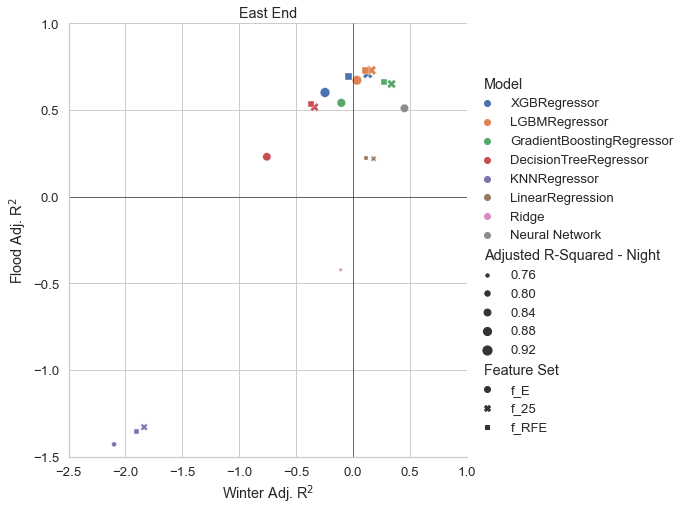

In [18]:
sns.set(font_scale = 1.2)
sns.set_style('whitegrid')

k=sns.relplot(x='Adjusted R-Squared - Winter',y='Adjusted R-Squared - Flood', data=ee,
            size='Adjusted R-Squared - Night',hue='Model',sizes=(10, 100),style='Feature Set',
            kind="scatter",height=7
            )
k.set(xlim=(-2.5, 1),ylim=(-1.5,1),xlabel = 'Winter Adj. R$^2$',ylabel = 'Flood Adj. R$^2$',Title='East End')

k.axes[0][0].axhline(0, ls='-', linewidth=0.5, color='black')
k.axes[0][0].axvline(0, ls='-', linewidth=0.5, color='black')

img=k.fig
img.savefig('EE Adj R2 Results RFE_2.jpg')

# MB

/opt/anaconda3/envs/ml/lib/python3.7/site-packages/seaborn/axisgrid.py:38: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set(**kwargs)


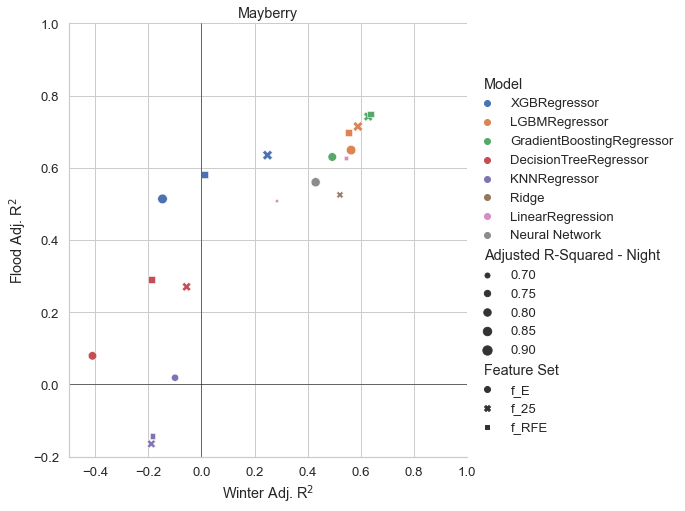

In [19]:
MB_fe=SCORES['MB']['f_e'][0]
MB_fe['Feature Set']='f_E'
MB_fe=MB_fe[~MB_fe.index.isin(['LAR','LassoCV'])]
MB_f25=SCORES['MB']['f_25'][0]
MB_f25['Feature Set']='f_25'
MB_f25=MB_f25[~MB_f25.index.isin(['LAR','LassoCV'])]
MB_fRFE=SCORES['MB']['F_RFE'][0]
MB_fRFE['Feature Set']='f_RFE'
MB_fRFE=MB_fRFE[~MB_fRFE.index.isin(['LAR','LassoCV'])]


mb=MB_fe.append(MB_f25).append(MB_fRFE).append(MB_NN).reset_index()

sns.set_style('whitegrid')
k=sns.relplot(x='Adjusted R-Squared - Winter',y='Adjusted R-Squared - Flood', data=mb,
            size='Adjusted R-Squared - Night',hue='Model',sizes=(10, 100),style='Feature Set',
            kind="scatter",height=7
            )
k.set(xlim=(-0.5, 1),ylim=(-0.2,1),xlabel = 'Winter Adj. R$^2$',ylabel = 'Flood Adj. R$^2$',Title='Mayberry')

k.axes[0][0].axhline(0, ls='-', linewidth=0.5, color='black')
k.axes[0][0].axvline(0, ls='-', linewidth=0.5, color='black')


img=k.fig
img.savefig('MB Adj R2 Results.jpg')

In [20]:
mb

,Model,Adjusted R-Squared - Night,R-Squared - Night,RMSE - Night,Slope - Night,Adjusted R-Squared - Winter,R-Squared - Winter,RMSE - Winter,Slope - Winter,Adjusted R-Squared - Flood,R-Squared - Flood,RMSE - Flood,Slope - Flood,Time/fold,Time (total),Feature Set,Site
0,XGBRegressor,0.92156,0.92157,0.28084,0.91927,-0.14641,-0.14563,0.82645,0.45912,0.51376,0.51528,0.78998,0.58210,3.22723,32.27231,f_E,NaN
1,LGBMRegressor,0.91225,0.91226,0.29707,0.90056,0.56340,0.56369,0.51213,0.58773,0.64895,0.65005,0.67280,0.58172,0.27871,2.78714,f_E,NaN
2,GradientBoostingRegressor,0.86051,0.86053,0.37460,0.82987,0.49254,0.49288,0.55070,0.57810,0.62990,0.63105,0.69081,0.72274,13.35278,133.52779,f_E,NaN
3,DecisionTreeRegressor,0.85448,0.85450,0.38247,0.92792,-0.40995,-0.40900,0.92000,0.67701,0.07933,0.08220,1.08755,0.58475,0.69685,6.96853,f_E,NaN
4,KNNRegressor,0.79046,0.79049,0.45909,0.78635,-0.09919,-0.09845,0.81259,0.28762,0.01866,0.02171,1.12497,0.23786,0.40970,4.09703,f_E,NaN
5,Ridge,0.65132,0.65137,0.59226,0.65163,0.28500,0.28548,0.65557,0.86327,0.50755,0.50908,0.79708,0.45094,0.01019,0.10186,f_E,NaN
6,LinearRegression,0.65132,0.65137,0.59226,0.65173,0.28440,0.28488,0.65585,0.86375,0.50762,0.50915,0.79702,0.45117,0.01321,0.13210,f_E,NaN
7,XGBRegressor,0.94768,0.94770,0.22929,0.94844,0.24876,0.25042,0.66725,0.64921,0.63482,0.63854,0.68239,0.75267,7.57409,75.74093,f_25,NaN
8,LGBMRegressor,0.94367,0.94370,0.23790,0.93465,0.58901,0.58992,0.49647,0.66448,0.71428,0.71719,0.60489,0.71093,0.60100,6.01002,f_25,NaN
9,GradientBoostingRegressor,0.90783,0.90787,0.30438,0.87942,0.62771,0.62853,0.47203,0.69111,0.74173,0.74436,0.57508,0.72273,50.84459,508.44587,f_25,NaN


# SW

/opt/anaconda3/envs/ml/lib/python3.7/site-packages/seaborn/axisgrid.py:38: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set(**kwargs)


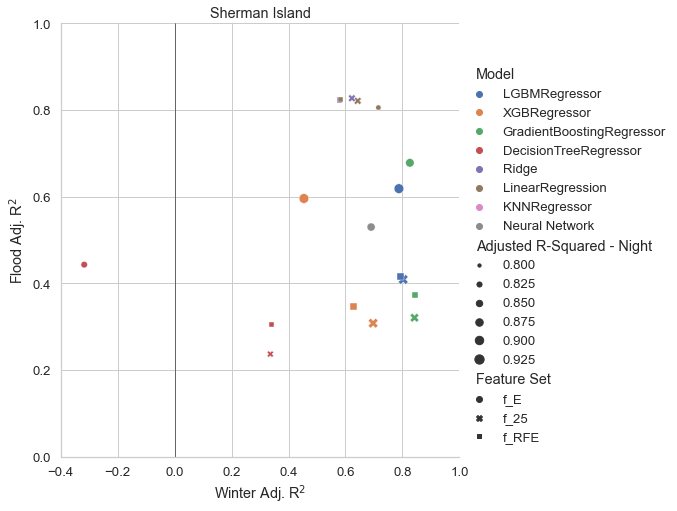

In [21]:
SW_fe=SCORES['SW']['f_e'][0]
SW_fe['Feature Set']='f_E'
SW_fe=SW_fe[~SW_fe.index.isin(['LAR','LassoCV'])]
SW_f25=SCORES['SW']['f_25'][0]
SW_f25['Feature Set']='f_25'
SW_f25=SW_f25[~SW_f25.index.isin(['LAR','LassoCV'])]
SW_fRFE=SCORES['SW']['F_RFE'][0]
SW_fRFE['Feature Set']='f_RFE'
SW_fRFE=SW_fRFE[~SW_fRFE.index.isin(['LAR','LassoCV'])]

sw=SW_fe.append(SW_f25).append(SW_fRFE).append(SW_NN).reset_index()

sns.set_style('whitegrid')

k=sns.relplot(x='Adjusted R-Squared - Winter',y='Adjusted R-Squared - Flood', data=sw,
            size='Adjusted R-Squared - Night',hue='Model',sizes=(10, 100),style='Feature Set',
            kind="scatter",height=7
            )
k.set(xlim=(-0.4, 1),ylim=(-0,1),xlabel = 'Winter Adj. R$^2$',ylabel = 'Flood Adj. R$^2$',Title='Sherman Island')

k.axes[0][0].axhline(0, ls='-', linewidth=0.5, color='black')
k.axes[0][0].axvline(0, ls='-', linewidth=0.5, color='black')


img=k.fig
img.savefig('SW Adj R2 Results.jpg')

In [22]:
sw

,Model,Adjusted R-Squared - Night,R-Squared - Night,RMSE - Night,Slope - Night,Adjusted R-Squared - Winter,R-Squared - Winter,RMSE - Winter,Slope - Winter,Adjusted R-Squared - Flood,R-Squared - Flood,RMSE - Flood,Slope - Flood,Time/fold,Time (total),Feature Set,Site
0,LGBMRegressor,0.93682,0.93685,0.27854,0.92841,0.78774,0.78817,0.39871,1.00898,0.61851,0.61903,1.41423,0.58311,0.16561,1.65608,f_E,NaN
1,XGBRegressor,0.93658,0.93661,0.27905,0.93703,0.45402,0.45513,0.63769,0.94660,0.59577,0.59633,1.45542,0.62622,1.24263,12.42630,f_E,NaN
2,GradientBoostingRegressor,0.90236,0.90240,0.34642,0.88071,0.82621,0.82656,0.36078,0.96727,0.67811,0.67855,1.29885,0.61824,4.16707,41.67066,f_E,NaN
3,DecisionTreeRegressor,0.85249,0.85256,0.42589,0.92866,-0.31783,-0.31516,0.99284,1.20350,0.44308,0.44385,1.69880,0.61862,0.19662,1.96615,f_E,NaN
4,Ridge,0.82677,0.82684,0.46140,0.82708,0.71639,0.71696,0.46101,1.07022,0.80504,0.80531,1.01102,0.70572,0.00682,0.06819,f_E,NaN
5,LinearRegression,0.82677,0.82684,0.46140,0.82756,0.71548,0.71606,0.46174,1.07217,0.80568,0.80594,1.00938,0.70720,0.00724,0.07244,f_E,NaN
6,KNNRegressor,0.79877,0.79886,0.49745,0.81052,-0.68434,-0.68094,1.12351,0.08266,-0.32642,-0.32459,2.63710,0.09336,0.16627,1.66272,f_E,NaN
7,XGBRegressor,0.94804,0.94811,0.25239,0.94739,0.69707,0.69907,0.47356,0.92015,0.30804,0.31116,1.89908,0.39375,2.62580,26.25797,f_25,NaN
8,LGBMRegressor,0.94696,0.94703,0.25491,0.93919,0.80283,0.80413,0.38331,0.94721,0.40896,0.41162,1.75688,0.41017,0.30664,3.06637,f_25,NaN
9,GradientBoostingRegressor,0.91880,0.91891,0.31569,0.89841,0.84242,0.84346,0.34258,0.92037,0.32062,0.32368,1.88398,0.35591,15.78259,157.82595,f_25,NaN


# WP Plotting

/opt/anaconda3/envs/ml/lib/python3.7/site-packages/seaborn/axisgrid.py:38: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set(**kwargs)


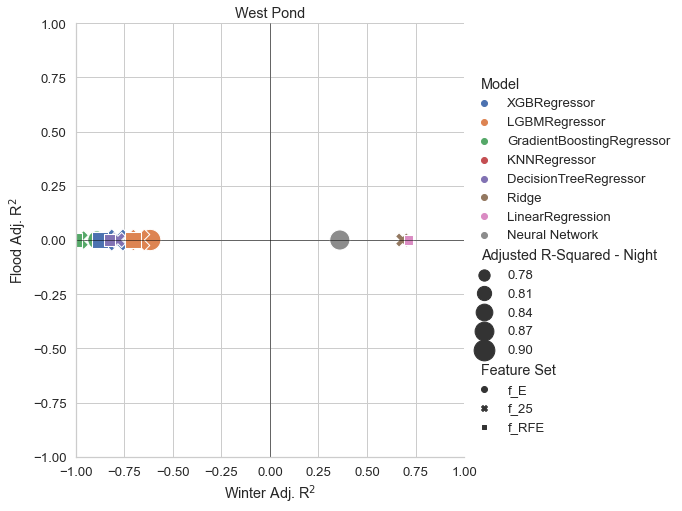

In [23]:
WP_fe=SCORES['WP']['f_e'][0]
WP_fe['Feature Set']='f_E'
WP_fe=WP_fe[~WP_fe.index.isin(['LAR','LassoCV'])]
WP_f25=SCORES['WP']['f_25'][0]
WP_f25['Feature Set']='f_25'
WP_f25=WP_f25[~WP_f25.index.isin(['LAR','LassoCV'])]
WP_fRFE=SCORES['WP']['F_RFE'][0]
WP_fRFE['Feature Set']='f_RFE'
WP_fRFE=WP_fRFE[~WP_fRFE.index.isin(['LAR','LassoCV'])]

wp=WP_fe.append(WP_f25).append(WP_fRFE).append(WP_NN).reset_index()
wp=wp.replace(np.NaN,0)

sns.set_style('whitegrid')

k=sns.relplot(x='Adjusted R-Squared - Winter',y='Adjusted R-Squared - Flood', data=wp,
            size='Adjusted R-Squared - Night',hue='Model',sizes=(100, 500),style='Feature Set',
            kind="scatter",height=7
            )
k.set(xlim=(-1, 1),ylim=(-1,1),xlabel = 'Winter Adj. R$^2$',ylabel = 'Flood Adj. R$^2$',Title='West Pond')

k.axes[0][0].axhline(0, ls='-', linewidth=0.5, color='black')
k.axes[0][0].axvline(0, ls='-', linewidth=0.5, color='black')


img=k.fig
img.savefig('WP Adj R2 Results.jpg')

In [24]:
wp

,Model,Adjusted R-Squared - Night,R-Squared - Night,RMSE - Night,Slope - Night,Adjusted R-Squared - Winter,R-Squared - Winter,RMSE - Winter,Slope - Winter,Time/fold,Time (total),Feature Set,Adjusted R-Squared - Flood,R-Squared - Flood,Slope - Flood,RMSE - Flood,Site
0,XGBRegressor,0.91997,0.91998,0.09442,0.92011,-1.05584,-1.05428,1.09983,0.15811,2.69140,26.91402,f_E,0.00000,0.00000,0.00000,0.00000,0
1,LGBMRegressor,0.90961,0.90962,0.10040,0.89195,-0.61706,-0.61583,0.97844,0.23208,0.30148,3.01483,f_E,0.00000,0.00000,0.00000,0.00000,0
2,GradientBoostingRegressor,0.86151,0.86153,0.12435,0.82730,-0.89204,-0.89061,1.05823,0.16966,11.91962,119.19618,f_E,0.00000,0.00000,0.00000,0.00000,0
3,KNNRegressor,0.81201,0.81204,0.14490,0.82380,-1.69482,-1.69277,1.26317,0.01869,0.27017,2.70169,f_E,0.00000,0.00000,0.00000,0.00000,0
4,DecisionTreeRegressor,0.80356,0.80359,0.14800,0.90724,-0.85668,-0.85527,1.04831,0.22843,0.63096,6.30960,f_E,0.00000,0.00000,0.00000,0.00000,0
5,Ridge,0.76910,0.76914,0.16064,0.76936,0.71484,0.71506,0.41091,0.63207,0.00818,0.08182,f_E,0.00000,0.00000,0.00000,0.00000,0
6,LinearRegression,0.76910,0.76914,0.16064,0.76949,0.71511,0.71533,0.41071,0.63251,0.01095,0.10947,f_E,0.00000,0.00000,0.00000,0.00000,0
7,XGBRegressor,0.92765,0.92769,0.08972,0.92884,-0.78657,-0.78213,1.02508,0.18223,6.72791,67.27912,f_25,0.00000,0.00000,0.00000,0.00000,0
8,LGBMRegressor,0.91914,0.91918,0.09489,0.90385,-0.67579,-0.67163,0.99509,0.21091,0.58294,5.82936,f_25,0.00000,0.00000,0.00000,0.00000,0
9,GradientBoostingRegressor,0.87162,0.87168,0.11971,0.83359,-0.98434,-0.97941,1.08298,0.14747,45.23803,452.38029,f_25,0.00000,0.00000,0.00000,0.00000,0


In [55]:
ee['Site']='EE'
ee['Col']=0
ee['Row']=0
mb['Site']='MB'
mb['Row']=0
mb['Col']=1
sw['Site']='SW'
sw['Col']=0
sw['Row']=1
wp['Site']='WP'
wp['Col']=1
wp['Row']=1

results=ee.append(mb)
results2=sw.append(wp)
results_all=ee.append(mb).append(sw).append(wp)

In [26]:
wp

,Model,Adjusted R-Squared - Night,R-Squared - Night,RMSE - Night,Slope - Night,Adjusted R-Squared - Winter,R-Squared - Winter,RMSE - Winter,Slope - Winter,Time/fold,Time (total),Feature Set,Adjusted R-Squared - Flood,R-Squared - Flood,Slope - Flood,RMSE - Flood,Site,Row
0,XGBRegressor,0.91997,0.91998,0.09442,0.92011,-1.05584,-1.05428,1.09983,0.15811,2.69140,26.91402,f_E,0.00000,0.00000,0.00000,0.00000,WP,0
1,LGBMRegressor,0.90961,0.90962,0.10040,0.89195,-0.61706,-0.61583,0.97844,0.23208,0.30148,3.01483,f_E,0.00000,0.00000,0.00000,0.00000,WP,0
2,GradientBoostingRegressor,0.86151,0.86153,0.12435,0.82730,-0.89204,-0.89061,1.05823,0.16966,11.91962,119.19618,f_E,0.00000,0.00000,0.00000,0.00000,WP,0
3,KNNRegressor,0.81201,0.81204,0.14490,0.82380,-1.69482,-1.69277,1.26317,0.01869,0.27017,2.70169,f_E,0.00000,0.00000,0.00000,0.00000,WP,0
4,DecisionTreeRegressor,0.80356,0.80359,0.14800,0.90724,-0.85668,-0.85527,1.04831,0.22843,0.63096,6.30960,f_E,0.00000,0.00000,0.00000,0.00000,WP,0
5,Ridge,0.76910,0.76914,0.16064,0.76936,0.71484,0.71506,0.41091,0.63207,0.00818,0.08182,f_E,0.00000,0.00000,0.00000,0.00000,WP,0
6,LinearRegression,0.76910,0.76914,0.16064,0.76949,0.71511,0.71533,0.41071,0.63251,0.01095,0.10947,f_E,0.00000,0.00000,0.00000,0.00000,WP,0
7,XGBRegressor,0.92765,0.92769,0.08972,0.92884,-0.78657,-0.78213,1.02508,0.18223,6.72791,67.27912,f_25,0.00000,0.00000,0.00000,0.00000,WP,0
8,LGBMRegressor,0.91914,0.91918,0.09489,0.90385,-0.67579,-0.67163,0.99509,0.21091,0.58294,5.82936,f_25,0.00000,0.00000,0.00000,0.00000,WP,0
9,GradientBoostingRegressor,0.87162,0.87168,0.11971,0.83359,-0.98434,-0.97941,1.08298,0.14747,45.23803,452.38029,f_25,0.00000,0.00000,0.00000,0.00000,WP,0


In [52]:
results_all

,Model,Adjusted R-Squared - Night,R-Squared - Night,RMSE - Night,Slope - Night,Adjusted R-Squared - Winter,R-Squared - Winter,RMSE - Winter,Slope - Winter,Adjusted R-Squared - Flood,R-Squared - Flood,RMSE - Flood,Slope - Flood,Time/fold,Time (total),Feature Set,Site,Row,Col
0,XGBRegressor,0.94461,0.94463,0.17851,0.94234,-0.24790,-0.24664,0.74236,0.57940,0.60088,0.60216,0.83465,0.66391,2.28138,22.81383,f_E,EE,0,0
1,LGBMRegressor,0.93707,0.93709,0.19017,0.92744,0.03222,0.03320,0.65584,0.58005,0.67159,0.67264,0.75826,0.67107,0.22188,2.21876,f_E,EE,0,0
2,GradientBoostingRegressor,0.89876,0.89879,0.24143,0.87580,-0.10465,-0.10353,0.69926,0.53198,0.54112,0.54258,0.89579,0.51960,9.05317,90.53166,f_E,EE,0,0
3,DecisionTreeRegressor,0.88732,0.88734,0.25454,0.93988,-0.75857,-0.75679,0.88404,0.65145,0.23001,0.23246,1.15748,0.64169,0.43468,4.34680,f_E,EE,0,0
4,KNNRegressor,0.78981,0.78985,0.34777,0.78926,-2.10010,-2.09697,1.17421,-0.04910,-1.42897,-1.42123,2.06264,0.03415,0.24302,2.43023,f_E,EE,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,KNNRegressor,0.84879,0.84883,0.12994,0.83145,-1.64191,-1.63845,1.25035,0.02920,0.00000,0.00000,0.00000,0.00000,21.59565,215.95654,f_RFE,WP,0,1
18,DecisionTreeRegressor,0.82647,0.82652,0.13917,0.91336,-0.82773,-0.82534,1.03970,0.22959,0.00000,0.00000,0.00000,0.00000,1.36393,13.63934,f_RFE,WP,0,1
19,Ridge,0.79842,0.79848,0.15004,0.79873,0.71363,0.71400,0.41166,0.64614,0.00000,0.00000,0.00000,0.00000,0.00959,0.09593,f_RFE,WP,0,1
20,LinearRegression,0.79842,0.79848,0.15004,0.79896,0.71313,0.71351,0.41202,0.64578,0.00000,0.00000,0.00000,0.00000,0.01344,0.13442,f_RFE,WP,0,1


/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


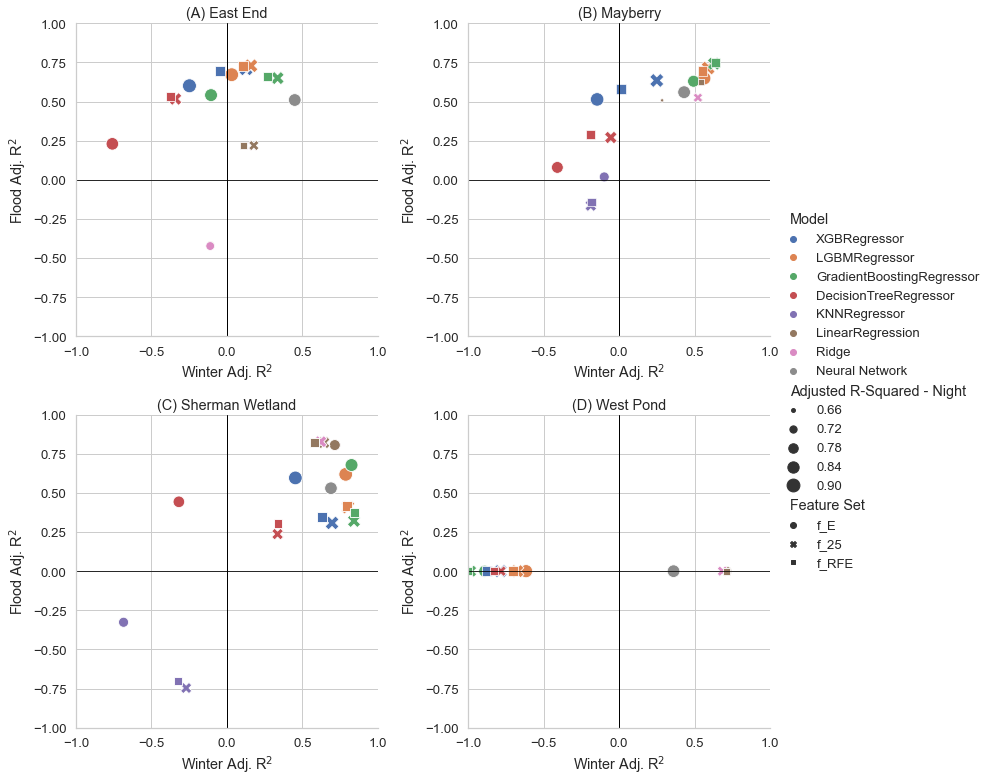

In [77]:
k=sns.relplot(x='Adjusted R-Squared - Winter',y='Adjusted R-Squared - Flood', data=results_all,
            size='Adjusted R-Squared - Night',hue='Model',sizes=(10, 200),style='Feature Set',
            kind="scatter",height=5.5,aspect=1,row='Row', col='Col', facet_kws={'sharey':False, 'sharex':False}
            )

#k.set(xlim=(-1, 1),ylim=(-1,1),xlabel = 'Winter Adj. R$^2$',ylabel = 'Flood Adj. R$^2$')


k.axes[0][0].axhline(0, ls='-', linewidth=0.8, color='black')
k.axes[1][0].axhline(0, ls='-', linewidth=0.8, color='black')
k.axes[0][1].axhline(0, ls='-', linewidth=0.8, color='black')
k.axes[1][1].axhline(0, ls='-', linewidth=0.8, color='black')

k.axes[0][0].axvline(0, ls='-', linewidth=1, color='black')
k.axes[1][0].axvline(0, ls='-', linewidth=1, color='black')
k.axes[0][1].axvline(0, ls='-', linewidth=1, color='black')
k.axes[1][1].axvline(0, ls='-', linewidth=1, color='black')

    
k.axes[0][0].set(xlim=(-1, 1),ylim=(-1,1),xlabel = 'Winter Adj. R$^2$',ylabel = 'Flood Adj. R$^2$',Title='(A) East End')
k.axes[0][1].set(xlim=(-1, 1),ylim=(-1,1),xlabel = 'Winter Adj. R$^2$',ylabel = 'Flood Adj. R$^2$',Title='(B) Mayberry')
k.axes[1][0].set(xlim=(-1, 1),ylim=(-1,1),xlabel = 'Winter Adj. R$^2$',ylabel = 'Flood Adj. R$^2$',Title='(C) Sherman Wetland')
k.axes[1][1].set(xlim=(-1, 1),ylim=(-1,1),xlabel = 'Winter Adj. R$^2$',ylabel = 'Flood Adj. R$^2$',Title='(D) West Pond')


plt.subplots_adjust(hspace=0.25, wspace=0.3)

img=k.fig
img.savefig('Adj R2 Results V3.jpg')

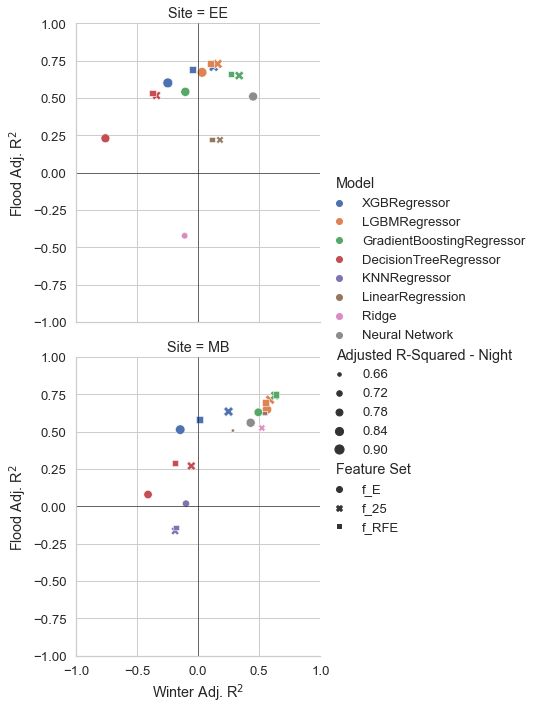

In [28]:
k=sns.relplot(x='Adjusted R-Squared - Winter',y='Adjusted R-Squared - Flood', data=results,
            size='Adjusted R-Squared - Night',hue='Model',sizes=(10, 100),style='Feature Set',
            kind="scatter",height=5,row='Site'
            )
k.set(xlim=(-1, 1),ylim=(-1,1),xlabel = 'Winter Adj. R$^2$',ylabel = 'Flood Adj. R$^2$')


for i in range(2):
    k.axes[i][0].axhline(0, ls='-', linewidth=0.5, color='black')
    k.axes[i][0].axvline(0, ls='-', linewidth=0.5, color='black')
    
    #k.axes[i][0].set(xlim=(-1, 1),ylim=(-1,1),xlabel = 'Winter Adj. R$^2$',ylabel = 'Flood Adj. R$^2$',Title='East End')

img=k.fig
img.savefig('Adj R2 Results.jpg')




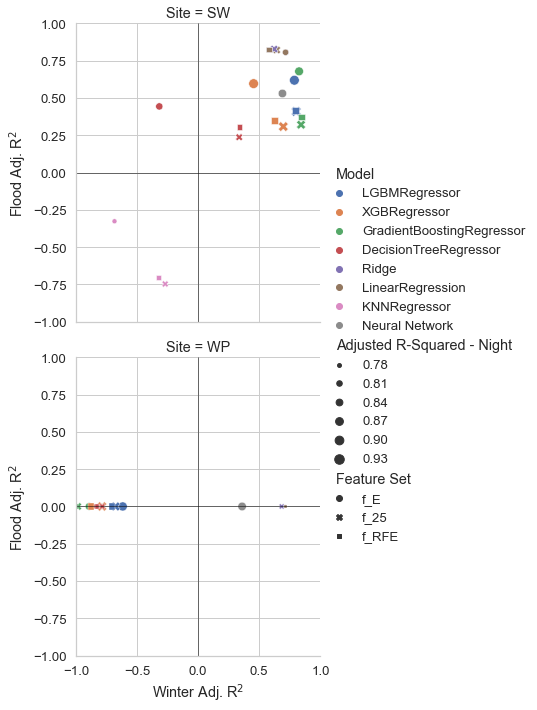

In [38]:
k=sns.relplot(x='Adjusted R-Squared - Winter',y='Adjusted R-Squared - Flood', data=results2,
            size='Adjusted R-Squared - Night',hue='Model',sizes=(10, 100),style='Feature Set',
            kind="scatter",height=5,row='Site'
            )
k.set(xlim=(-1, 1),ylim=(-1,1),xlabel = 'Winter Adj. R$^2$',ylabel = 'Flood Adj. R$^2$')


for i in range(2):
    k.axes[i][0].axhline(0, ls='-', linewidth=0.5, color='black')
    k.axes[i][0].axvline(0, ls='-', linewidth=0.5, color='black')
    
    #k.axes[i][0].set(xlim=(-1, 1),ylim=(-1,1),xlabel = 'Winter Adj. R$^2$',ylabel = 'Flood Adj. R$^2$',Title='East End')

img=k.fig
img.savefig('Adj R2 Results 2.jpg')




In [44]:
SCORES['EE'][2][0]

,Adjusted R-Squared - Night,R-Squared - Night,RMSE - Night,Slope - Night,Adjusted R-Squared - Winter,R-Squared - Winter,RMSE - Winter,Slope - Winter,Adjusted R-Squared - Flood,R-Squared - Flood,RMSE - Flood,Time/fold,Time (total)
Model,,,,,,,,,,,,,
XGBRegressor,0.955027,0.955057,0.204874,0.955578,0.149863,0.152677,0.781655,0.734321,0.713427,0.716417,0.899690,5.368314,53.683138
LGBMRegressor,0.949389,0.949423,0.217173,0.940749,0.151861,0.154669,0.782505,0.728603,0.723920,0.726801,0.883885,0.450395,4.503954
KNNRegressor,0.924751,0.924800,0.265127,0.900489,-1.438225,-1.430153,1.327026,0.105982,-1.121038,-1.098906,2.450128,15.671750,156.717499
GradientBoostingRegressor,0.914168,0.914225,0.283223,0.894054,0.315767,0.318033,0.702561,0.593555,0.641549,0.645289,1.007040,34.233132,342.331319
DecisionTreeRegressor,0.895319,0.895387,0.312610,0.942903,-0.343596,-0.339148,0.984337,0.690087,0.516778,0.521821,1.169279,1.596388,15.963878
LinearRegression,0.804336,0.804465,0.427938,0.805570,0.178971,0.181689,0.770052,0.414830,0.218967,0.227117,1.486723,0.020816,0.208161
LAR,0.804336,0.804465,0.427938,0.805570,0.178971,0.181689,0.770052,0.414830,0.218967,0.227117,1.486723,0.018383,0.183832
Ridge,0.804335,0.804464,0.427939,0.805471,0.174707,0.177439,0.772049,0.411222,0.215989,0.224170,1.489560,0.013727,0.137267
LassoCV,0.804335,0.804464,0.427939,0.805471,0.174707,0.177439,0.772049,0.411222,0.215989,0.224170,1.489560,0.014620,0.146199


In [45]:
SCORES['MB'][2][0]

,Adjusted R-Squared - Night,R-Squared - Night,RMSE - Night,Slope - Night,Adjusted R-Squared - Winter,R-Squared - Winter,RMSE - Winter,Slope - Winter,Adjusted R-Squared - Flood,R-Squared - Flood,RMSE - Flood,Time/fold,Time (total)
Model,,,,,,,,,,,,,
XGBRegressor,0.947970,0.947993,0.204372,0.949834,0.168838,0.170671,0.628424,0.765166,0.627538,0.631332,0.616965,7.956213,79.562134
LGBMRegressor,0.943539,0.943564,0.212931,0.934218,0.585254,0.586169,0.445672,0.702661,0.710320,0.713271,0.544416,0.625209,6.252088
KNNRegressor,0.917847,0.917884,0.256891,0.899687,0.206918,0.208668,0.616568,0.364654,0.263285,0.270790,0.868203,34.909569,349.095694
GradientBoostingRegressor,0.907530,0.907571,0.272518,0.879828,0.662606,0.663350,0.401928,0.725448,0.747302,0.749876,0.508437,51.714986,517.149860
DecisionTreeRegressor,0.884437,0.884488,0.304595,0.942442,-0.062129,-0.059786,0.712484,0.644986,0.263962,0.271460,0.866104,2.501392,25.013916
LinearRegression,0.774742,0.774841,0.425411,0.775452,0.521275,0.522331,0.479092,0.536632,0.524605,0.529448,0.697486,0.028463,0.284628
Ridge,0.774717,0.774816,0.425434,0.775285,0.522681,0.523734,0.478388,0.536630,0.525648,0.530480,0.696720,0.017561,0.175614
LassoCV,0.774717,0.774816,0.425434,0.775285,0.522681,0.523734,0.478388,0.536630,0.525648,0.530480,0.696720,0.017064,0.170637
LAR,-232.058745,-231.956058,10.980351,1.228918,-437.138928,-436.172267,11.684103,0.714798,-280.253214,-277.388156,13.748876,0.022718,0.227179


In [46]:
SCORES['SW'][2][0]

,Adjusted R-Squared - Night,R-Squared - Night,RMSE - Night,Slope - Night,Adjusted R-Squared - Winter,R-Squared - Winter,RMSE - Winter,Slope - Winter,Adjusted R-Squared - Flood,R-Squared - Flood,RMSE - Flood,Time/fold,Time (total)
Model,,,,,,,,,,,,,
XGBRegressor,9.481892e-01,9.482610e-01,0.158262,0.946678,7.177709e-01,7.196393e-01,2.871726e-01,4.055147e-01,3.368633e-01,3.398553e-01,1.166360e+00,5.192378,51.923781
LGBMRegressor,9.474368e-01,9.475096e-01,0.159379,0.939031,8.045358e-01,8.058298e-01,2.394316e-01,4.218149e-01,4.208868e-01,4.234997e-01,1.091122e+00,0.296935,2.969346
GradientBoostingRegressor,9.185109e-01,9.186238e-01,0.198531,0.898101,8.408083e-01,8.418621e-01,2.161126e-01,3.545795e-01,3.211913e-01,3.242539e-01,1.180687e+00,44.443213,444.432127
KNNRegressor,9.106434e-01,9.107672e-01,0.207879,0.897551,3.463955e-01,3.507224e-01,4.380094e-01,1.989709e-01,4.082641e-02,4.515405e-02,1.404670e+00,5.888600,58.886003
LinearRegression,8.761450e-01,8.763166e-01,0.244802,0.877107,-2.645395e+19,-2.627883e+19,1.237251e+09,-1.318450e+07,-5.653974e+17,-5.628464e+17,4.787880e+08,0.012785,0.127855
Ridge,8.746881e-01,8.748616e-01,0.246234,0.875309,6.034743e-01,6.060994e-01,3.412251e-01,7.212030e-01,8.314542e-01,8.322147e-01,5.889007e-01,0.009169,0.091688
LassoCV,8.746881e-01,8.748616e-01,0.246234,0.875309,6.034743e-01,6.060994e-01,3.412251e-01,7.212030e-01,8.314542e-01,8.322147e-01,5.889007e-01,0.010256,0.102558
DecisionTreeRegressor,8.531522e-01,8.533556e-01,0.266457,0.917556,3.679879e-01,3.721719e-01,4.299854e-01,3.868937e-01,2.731023e-01,2.763820e-01,1.217250e+00,0.678538,6.785384
LAR,-6.544889e+06,-6.535825e+06,1080.915992,-38.130385,-2.800825e+07,-2.782283e+07,1.736427e+03,8.870477e+02,-7.962282e+06,-7.926358e+06,2.455673e+03,0.014767,0.147666


# Recursive Feature Elimination

In [14]:
def lgbm_train_test(train,test,winter,flood=[],features=['TW_mean','wq_gf'],preds=False,verbose=False):
    
    #If you don't want to pass the train & test sets, uncomment this and change the input variable to night
    #test=night.sample(frac=0.1)
    #train=night[~night.index.isin(test.index)]
    
    LGR=lightgbm.LGBMRegressor(importance_type='gain')
    LGR.fit(train[features], train['wq_gf'])
    
    test_X=test[features]
    test_y=test.wq_gf
    winter_X=winter[features]
    winter_y=winter.wq_gf
    
    test_pred=pd.Series(data=LGR.predict(test_X),index=test.index)
    winter_pred=pd.Series(data=LGR.predict(winter_X),index=winter.index)
    
    #test scores
    r_squared = r2_score(test_y, test_pred)
    adj_rsquared = adjusted_rsquared(r_squared, test_X.shape[0], test_X.shape[1])    
    
    #winter scores
    winter_r_squared = r2_score(winter_y, winter_pred)
    winter_adj_rsquared = adjusted_rsquared(
        winter_r_squared, winter_X.shape[0], winter_X.shape[1]
    )
    
    if(len(flood)):
        flood_X=flood[features]
        flood_y=flood.wq_gf
        
        flood_pred=pd.Series(data=LGR.predict(flood_X),index=flood.index)
        
        #winter scores
        flood_r_squared = r2_score(flood_y, flood_pred)
        flood_adj_rsquared = adjusted_rsquared(flood_r_squared, flood_X.shape[0], flood_X.shape[1])
    
        scores=[adj_rsquared,winter_adj_rsquared,flood_adj_rsquared]
    else:
        scores=[adj_rsquared,winter_adj_rsquared]
    
    if verbose:
        print(f'Test Adj. R2: {adj_rsquared}')
        print(f'Winter Adj. R2: {winter_adj_rsquared}')
        if(len(flood)):
            print(f'Flood Adj. R2: {flood_adj_rsquared}')
    
    i=LGR.feature_importances_
    I=pd.Series(data=i,index=features).sort_values(ascending=False)
    #lightgbm.plot_importance(LGR,importance_type='gain')
    
    #lightgbm.create_tree_digraph(LGR)
    
    if preds: 
        return scores,I,test_preds,winter_preds,flood_preds
    else: 
        return scores,I

In [17]:
RFE_RESULTS={'EE':[],'MB':[],'SW':[],'WP':[]}
sites={'WP':[WP_n,WP_w],'EE':[EE_n,EE_w,EE_f],'MB':[MB_n,MB_w,MB_f],'SW':[SW_n,SW_w,SW_f]}

f_25_X=f_25.copy()
f_25_X.remove('wq_gf')

nsplits=5

for site_id in sites:
    print(site_id)
    features=f_25_X
    
    RFE_SCORES=[]    
    RFE_SCORES=[]
    RFE_I=[]
    
    for i in range(len(f_25_X)):
        num_features=len(features)
        print(f'    Number of features:{num_features}')
        
        #Cross validation loop
        CV_I=[]
        CV_SCORES=[]
        kf = KFold(n_splits=nsplits)
        for train_idx, test_idx in kf.split(sites[site_id][0]):
            
            if(site_id=='WP'):
                scores, I = lgbm_train_test(sites[site_id][0].iloc[train_idx],
                                        sites[site_id][0].iloc[test_idx],
                                        sites[site_id][1],
                                        features=features)
            else:
                scores, I = lgbm_train_test(sites[site_id][0].iloc[train_idx],
                                        sites[site_id][0].iloc[test_idx],
                                        sites[site_id][1],
                                        sites[site_id][2],
                                        features=features)    
                
            
            CV_SCORES.append(scores)

            if(len(CV_I)):
                CV_I=CV_I+I
            else:
                CV_I=I
                
            #End CV Loop
        
        
        #Still in RFE Loop
        I_final=CV_I/nsplits
        I_final.sort_values(inplace=True,ascending=False)
        RFE_I.append(I_final)
        features=I_final.iloc[:-1].index
        
        if(site_id=='WP'):
            score_final=pd.DataFrame(data=CV_SCORES,columns=['Night','Winter']).mean()
        else:
            score_final=pd.DataFrame(data=CV_SCORES,columns=['Night','Winter','Flood']).mean()
            
        #print(score_final)
        RFE_SCORES.append(np.append(score_final.values,num_features))
        
        #Drop one feature
    
    #Collate the results for that site
    results={'Scores':RFE_SCORES,'Importances':RFE_I}
    RFE_RESULTS[site_id]=results

WP
    Number of features:36
    Number of features:35
    Number of features:34
    Number of features:33
    Number of features:32
    Number of features:31
    Number of features:30
    Number of features:29
    Number of features:28
    Number of features:27
    Number of features:26
    Number of features:25
    Number of features:24
    Number of features:23
    Number of features:22
    Number of features:21
    Number of features:20
    Number of features:19
    Number of features:18
    Number of features:17
    Number of features:16
    Number of features:15
    Number of features:14
    Number of features:13
    Number of features:12
    Number of features:11
    Number of features:10
    Number of features:9
    Number of features:8
    Number of features:7
    Number of features:6
    Number of features:5
    Number of features:4
    Number of features:3
    Number of features:2
    Number of features:1
EE
    Number of features:36
    Number of features:35
    Number of f

In [18]:
with open('RFE_RESULTS.pkl', 'wb') as out_file:
    pickle.dump(RFE_RESULTS, out_file)

In [2]:
with open('RFE_RESULTS.pkl', 'rb') as f:
    RFE_RESULTS = pickle.load(f)

In [45]:
sns.set(font_scale = 1.2)
sns.set_style('whitegrid')

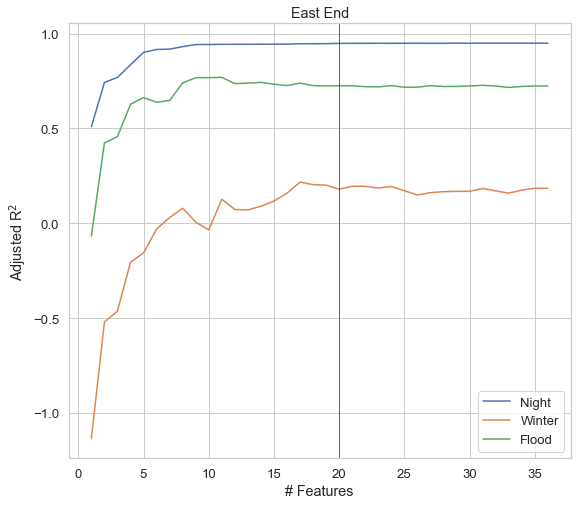

In [46]:
EE_RFE=pd.DataFrame(data=RFE_RESULTS['EE']['Scores'],
             columns=['Night','Winter','Flood','# Features'])
EE_RFE.set_index(EE_RFE['# Features'].astype(int),inplace=True)
EE_RFE.drop(columns="# Features",inplace=True)
ax=EE_RFE.plot(figsize=(9,8))
ax.set_ylabel('Adjusted R$^2$')
ax.set_title('East End')
ax.axvline(20, ls='-', linewidth=0.5, color='black')
#ax.axvline(9, ls='-', linewidth=0.5, color='black')
fig = ax.get_figure()
fig.savefig("EE_RFE.png")

In [4]:
EE_RFE['% Drop']=100*EE_RFE.Night.diff()/EE_RFE.Night.iloc[0]

In [5]:
EE_RFE

,Night,Winter,Flood,% Drop
# Features,,,,
36,0.94923,0.18496,0.72379,NaN
35,0.94924,0.18503,0.72384,0.00034
34,0.94931,0.17526,0.72142,0.00757
33,0.94932,0.15911,0.71623,0.00154
32,0.94934,0.17115,0.72361,0.00180
31,0.94929,0.18398,0.72741,-0.00499
30,0.94918,0.16875,0.72402,-0.01167
29,0.94929,0.16876,0.72151,0.01139
28,0.94902,0.16718,0.72114,-0.02830


In [6]:
#Have to reverse the order of the list -> [::-1]
EE_I_RFE=RFE_RESULTS['EE']['Importances'][::-1][19]
EE_I_RFE

TW_mean   36908.80962
ubar      24387.60447
cbar      16275.94019
RH         9767.53428
year       9380.36326
VPD        6679.41885
ustar      6325.02624
H_gf       4216.16036
TS_mean    2914.27224
DOY        2783.33781
uw         2137.21251
RNET       1760.58425
ww          917.05391
WT          810.98641
stat_q      571.09040
wm_gf       506.03815
ze          480.02351
time        389.09709
tbar        379.04996
WD          321.89573
dtype: float64

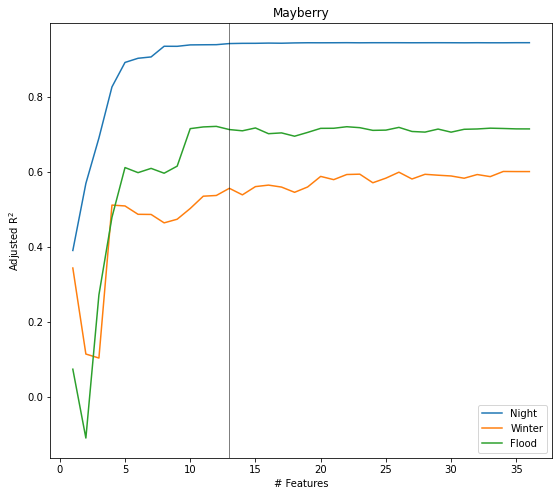

In [7]:
MB_RFE=pd.DataFrame(data=RFE_RESULTS['MB']['Scores'],
             columns=['Night','Winter','Flood','# Features'])
MB_RFE.set_index(MB_RFE['# Features'].astype(int),inplace=True)
MB_RFE.drop(columns="# Features",inplace=True)
ax=MB_RFE.plot(figsize=(9,8))
ax.set_ylabel('Adjusted R$^2$')
ax.set_title('Mayberry')
#>0.1% Drop in R2
ax.axvline(13, ls='-', linewidth=0.5, color='black')
#>1% Drop in R2
#ax.axvline(8, ls='-', linewidth=0.5, color='black')
fig = ax.get_figure()
fig.savefig("MB_RFE.png")

In [8]:
MB_RFE['% Drop']=100*MB_RFE.Night.diff()/MB_RFE.Night.iloc[0]
MB_RFE

,Night,Winter,Flood,% Drop
# Features,,,,
36,0.94363,0.59989,0.71367,NaN
35,0.94363,0.59992,0.71375,0.00045
34,0.94341,0.60018,0.71482,-0.02299
33,0.94340,0.58645,0.71564,-0.00174
32,0.94356,0.59199,0.71352,0.01676
31,0.94335,0.58214,0.71268,-0.02198
30,0.94350,0.58816,0.70502,0.01656
29,0.94358,0.59021,0.71326,0.00792
28,0.94353,0.59262,0.70516,-0.00568


In [9]:
#Have to reverse the order of the list -> [::-1]
#Importances are indexed from 0, so the nth set of importances has n+1 features
MB_I_RFE=RFE_RESULTS['MB']['Importances'][::-1][12]
MB_I_RFE

wm_gf       59288.67491
ustar       55841.54732
year        36972.44979
RH          36968.24137
ubar        30161.50886
TW_mean     26846.09019
cbar        24786.86169
DOY         19749.34366
VPD         19578.49946
H_gf         6722.65599
er_linear    5140.66319
ww           3965.79467
WD           3316.37223
dtype: float64

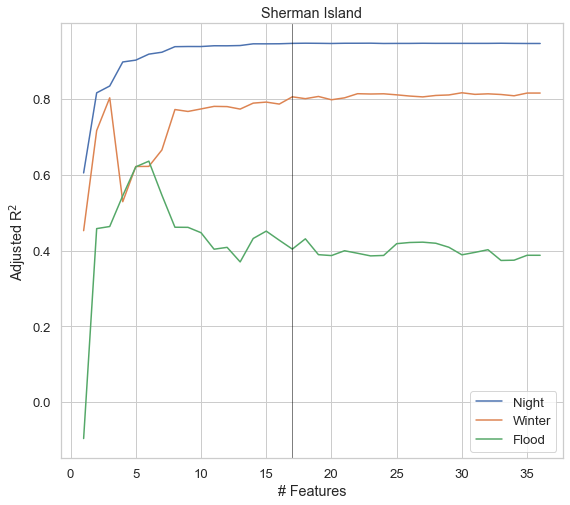

In [47]:
SW_RFE=pd.DataFrame(data=RFE_RESULTS['SW']['Scores'],
             columns=['Night','Winter','Flood','# Features'])
SW_RFE.set_index(SW_RFE['# Features'].astype(int),inplace=True)
SW_RFE.drop(columns="# Features",inplace=True)
ax=SW_RFE.plot(figsize=(9,8))
ax.set_ylabel('Adjusted R$^2$')
ax.set_title('Sherman Island')
#0.1% Drop in R2
ax.axvline(17, ls='-', linewidth=0.5, color='black')
#1% Drop in R2
#ax.axvline(8, ls='-', linewidth=0.5, color='black')
fig = ax.get_figure()
fig.savefig("SW_RFE.png")

In [11]:
SW_RFE['% Drop']=100*SW_RFE.Night.diff()/SW_RFE.Night.iloc[0]
SW_RFE

,Night,Winter,Flood,% Drop
# Features,,,,
36,0.94602,0.81529,0.38744,NaN
35,0.94603,0.81527,0.38748,0.00091
34,0.94625,0.80808,0.37451,0.02315
33,0.94664,0.81150,0.37381,0.04184
32,0.94631,0.81325,0.40215,-0.03553
31,0.94630,0.81186,0.39512,-0.00085
30,0.94634,0.81604,0.38868,0.00455
29,0.94637,0.81028,0.40860,0.00307
28,0.94635,0.80899,0.41919,-0.00176


In [12]:
SW_I_RFE=RFE_RESULTS['SW']['Importances'][::-1][16]
SW_I_RFE

ubar        71505.55831
VPD         22041.16155
ustar        6337.76270
H_gf         6147.22620
TW_mean      5383.13998
wm_gf        4483.60641
RH           3343.10260
DOY          2891.61881
tbar         2709.39351
time         1007.15883
uw            907.17981
ww            848.43491
RNET          737.78754
year          560.41589
TS_mean       494.59241
er_linear     470.06035
WD            311.86743
dtype: float64

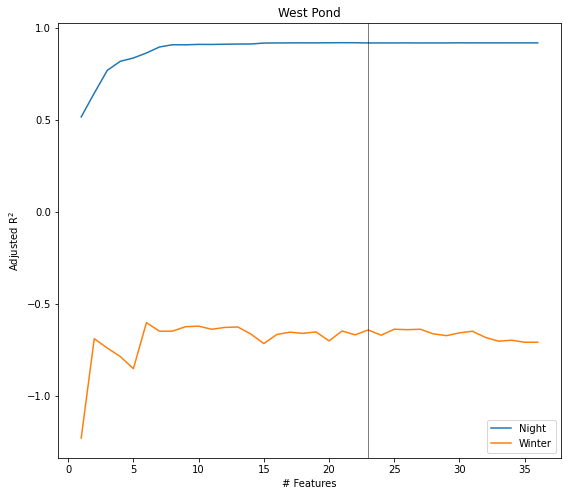

In [13]:
WP_RFE=pd.DataFrame(data=RFE_RESULTS['WP']['Scores'],
             columns=['Night','Winter','# Features'])
WP_RFE.set_index(WP_RFE['# Features'].astype(int),inplace=True)
WP_RFE.drop(columns="# Features",inplace=True)
ax=WP_RFE.plot(figsize=(9,8))
ax.set_ylabel('Adjusted R$^2$')
ax.set_title('West Pond')
#>0.1% drop in R2
ax.axvline(23, ls='-', linewidth=0.5, color='black')
#>1% drop in R2
#ax.axvline(8, ls='-', linewidth=0.5, color='black')
fig = ax.get_figure()
fig.savefig("WP_RFE.png")

In [14]:
WP_RFE['% Drop']=100*WP_RFE.Night.diff()/WP_RFE.Night.iloc[0]
WP_RFE

,Night,Winter,% Drop
# Features,,,
36,0.91847,-0.70792,NaN
35,0.91848,-0.70781,0.00068
34,0.91845,-0.69688,-0.00315
33,0.91862,-0.70216,0.01861
32,0.91856,-0.68219,-0.00723
31,0.91847,-0.64801,-0.00901
30,0.91883,-0.65689,0.03847
29,0.91820,-0.67206,-0.06847
28,0.91836,-0.66234,0.01738


In [15]:
WP_I_RFE=RFE_RESULTS['WP']['Importances'][::-1][22]
WP_I_RFE

H_gf          13692.37265
ustar          5791.65687
RNET           3027.88692
VPD            1674.82043
RH             1450.90779
DOY            1043.08882
year            673.65416
TA              526.24763
uw              525.69694
wm_gf           442.85099
uu              402.89490
WD              303.54614
TS_mean         275.47896
time            206.86947
TW_mean         183.05676
sos             138.01113
er_linear       128.99739
WT              117.18280
tsbar           110.09820
ubar            106.59559
rho_mol_Met      97.96551
vv               97.30151
ze               80.62885
dtype: float64

In [16]:
EE_RFE=pd.DataFrame(data=RFE_RESULTS['EE']['Scores'],
             columns=['Night','Winter','Flood','# Features'])
EE_RFE.set_index(EE_RFE['# Features'].astype(int),inplace=True)
EE_RFE.drop(columns="# Features",inplace=True)
EE_RFE['Site']='EE'

MB_RFE=pd.DataFrame(data=RFE_RESULTS['MB']['Scores'],
             columns=['Night','Winter','Flood','# Features'])
MB_RFE.set_index(MB_RFE['# Features'].astype(int),inplace=True)
MB_RFE.drop(columns="# Features",inplace=True)
MB_RFE['Site']='MB'

SW_RFE=pd.DataFrame(data=RFE_RESULTS['SW']['Scores'],
             columns=['Night','Winter','Flood','# Features'])
SW_RFE.set_index(SW_RFE['# Features'].astype(int),inplace=True)
SW_RFE.drop(columns="# Features",inplace=True)
SW_RFE['Site']='SW'

WP_RFE=pd.DataFrame(data=RFE_RESULTS['WP']['Scores'],
             columns=['Night','Winter','# Features'])
WP_RFE.set_index(WP_RFE['# Features'].astype(int),inplace=True)
WP_RFE.drop(columns="# Features",inplace=True)
WP_RFE['Site']='WP'

RFE=EE_RFE.append(MB_RFE).append(SW_RFE).append(WP_RFE)
RFE=RFE.reset_index()

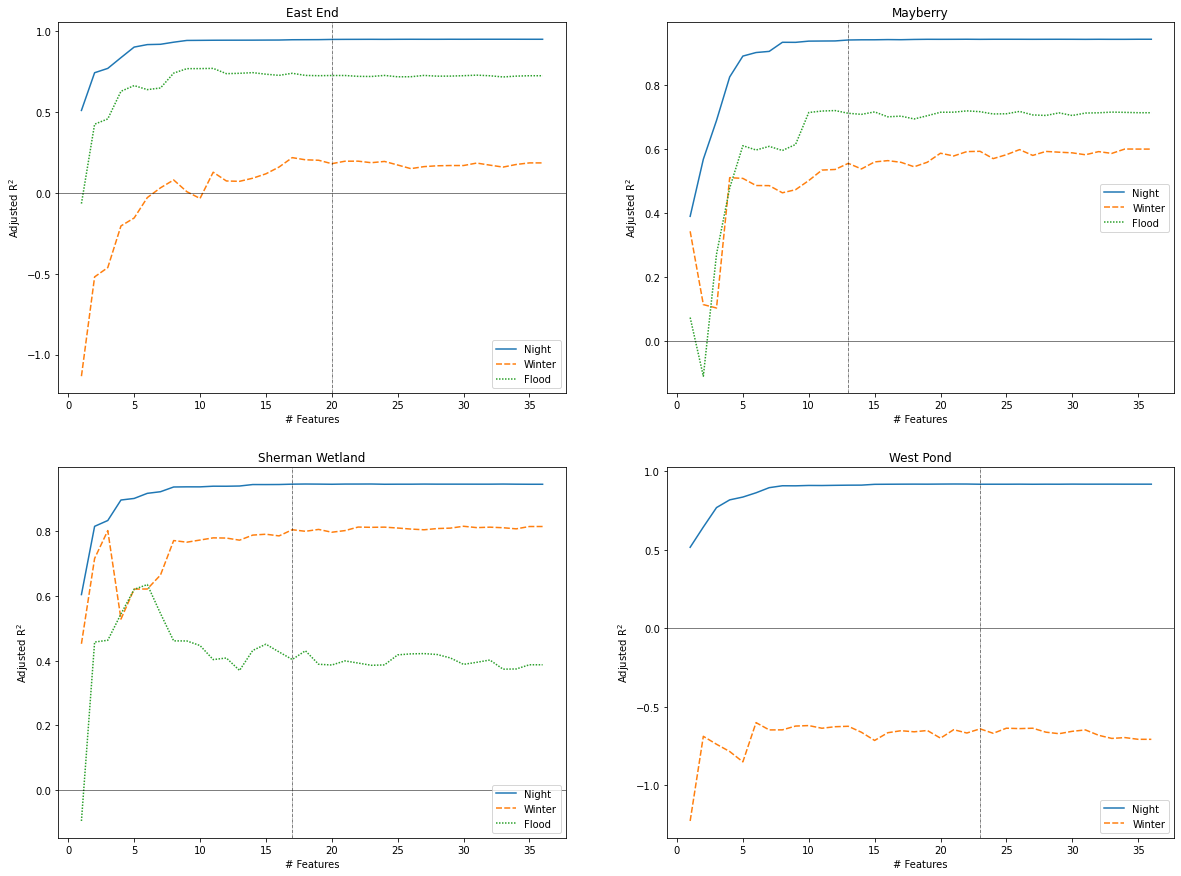

In [17]:
#Plot all RFE curves

figure, axes = plt.subplots(2, 2,figsize=(20, 15))

sns.lineplot(data=EE_RFE,ax=axes[0][0])
sns.lineplot(data=MB_RFE,ax=axes[0][1])
sns.lineplot(data=SW_RFE,ax=axes[1][0])
sns.lineplot(data=WP_RFE,ax=axes[1][1])

axes[1][0].set_xlabel('# Features')
axes[0][1].set_xlabel('# Features')
axes[1][0].set_xlabel('# Features')
axes[1][1].set_xlabel('# Features')
axes[0][0].set_ylabel('Adjusted R$^2$')
axes[0][1].set_ylabel('Adjusted R$^2$')
axes[1][0].set_ylabel('Adjusted R$^2$')
axes[1][1].set_ylabel('Adjusted R$^2$')

axes[0][0].set_title('East End')
axes[0][1].set_title('Mayberry')
axes[1][0].set_title('Sherman Wetland')
axes[1][1].set_title('West Pond')

axes[0][0].axvline(20, ls='dashdot', linewidth=0.5, color='black')
axes[0][1].axvline(13, ls='dashdot', linewidth=0.5, color='black')
axes[1][0].axvline(17, ls='dashdot', linewidth=0.5, color='black')
axes[1][1].axvline(23, ls='dashdot', linewidth=0.5, color='black')

axes[0][0].axhline(0, ls='-', linewidth=0.5, color='black')
axes[0][1].axhline(0, ls='-', linewidth=0.5, color='black')
axes[1][0].axhline(0, ls='-', linewidth=0.5, color='black')
axes[1][1].axhline(0, ls='-', linewidth=0.5, color='black')

axes[0][0].tick_params(axis='both', which='both', labelbottom=True)
axes[0][1].tick_params(axis='both', which='both', labelbottom=True)

plt.savefig('RFE Results.png')
plt.show()

In [18]:
import os
os.getcwd()

'/Users/adam/Documents/Code/California Wetland Code (Consolidated)'

# Feature Importances for selected features

In [32]:
F=pd.DataFrame({'EE':EE_I_RFE,'SW':SW_I_RFE,'MB':MB_I_RFE,'WP':WP_I_RFE})
F=F/F.sum()
F['Scaled Mean']=F.mean(axis=1)
F['Mean']=F.drop(columns='Scaled Mean').mean(axis=1)
F['Frequency']=((4-F.isnull().sum(axis=1))).astype(int)
F=F.sort_values(['Frequency','Scaled Mean'],ascending=False)
F['Frequency']=F.Frequency.astype(str)+'/4'
F.fillna(0,inplace=True)

F2=pd.DataFrame(F)
F[['EE','SW','MB','WP']].style.background_gradient(cmap='PuBuGn')

,EE,SW,MB,WP
ubar,0.190660,0.549282,0.091582,0.003428
H_gf,0.032962,0.047221,0.020413,0.440300
ustar,0.049448,0.048685,0.169557,0.186240
TW_mean,0.288550,0.041351,0.081515,0.005886
VPD,0.052219,0.169313,0.059448,0.053857
RH,0.076362,0.025681,0.112250,0.046656
wm_gf,0.003956,0.034442,0.180023,0.014241
year,0.073335,0.004305,0.112263,0.021662
DOY,0.021760,0.022212,0.059967,0.033542
WD,0.002517,0.002396,0.010070,0.009761


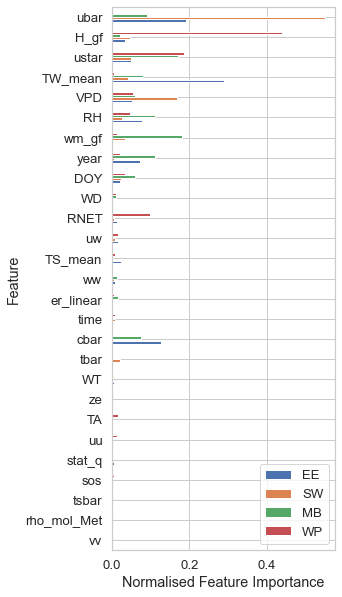

In [58]:
sns.set(font_scale = 1.2)
sns.set_style('whitegrid')
ax=F[['EE','SW','MB','WP']].iloc[::-1].plot(kind='barh',figsize=(4,10))
ax.set(xlabel="Normalised Feature Importance", ylabel="Feature")
ax.legend(loc='lower right')

In [23]:
pd.DataFrame({'EE':EE_I_RFE})

,EE
TW_mean,36908.80962
ubar,24387.60447
cbar,16275.94019
RH,9767.53428
year,9380.36326
VPD,6679.41885
ustar,6325.02624
H_gf,4216.16036
TS_mean,2914.27224
DOY,2783.33781


In [24]:
EE_F=pd.DataFrame({'Total Gain':EE_I_RFE}).reset_index().reset_index()
EE_F['Rank']=EE_F.level_0+1
EE_F.rename(columns={'index':'Feature'},inplace=True)
EE_F.drop('level_0',axis=1,inplace=True)
#EE_F=EE_F[['Total Gain','Rank']]
EE_F['Relative Importance']=EE_F['Total Gain']/EE_F['Total Gain'].sum()
EE_F.index=EE_F.Rank
EE_F.drop('Rank',axis=1,inplace=True)
EE_F.style.background_gradient(cmap='Greens')

,Feature,Total Gain,Relative Importance
Rank,,,
1,TW_mean,36908.809617,0.288550
2,ubar,24387.604467,0.190660
3,cbar,16275.940186,0.127244
4,RH,9767.534281,0.076362
5,year,9380.363263,0.073335
6,VPD,6679.418848,0.052219
7,ustar,6325.026244,0.049448
8,H_gf,4216.160356,0.032962
9,TS_mean,2914.272238,0.022784


In [25]:
SW_F=pd.DataFrame({'Total Gain':SW_I_RFE}).reset_index().reset_index()
SW_F['Rank']=SW_F.level_0+1
SW_F.rename(columns={'index':'Feature'},inplace=True)
SW_F.drop('level_0',axis=1,inplace=True)
#SW_F=SW_F[['Total Gain','Rank']]
SW_F['Relative Importance']=SW_F['Total Gain']/SW_F['Total Gain'].sum()
SW_F.index=SW_F.Rank
SW_F.drop('Rank',axis=1,inplace=True)
SW_F.style.background_gradient(cmap='Greens')

,Feature,Total Gain,Relative Importance
Rank,,,
1,ubar,71505.558315,0.549282
2,VPD,22041.161554,0.169313
3,ustar,6337.762699,0.048685
4,H_gf,6147.226199,0.047221
5,TW_mean,5383.139979,0.041351
6,wm_gf,4483.606409,0.034442
7,RH,3343.102605,0.025681
8,DOY,2891.618814,0.022212
9,tbar,2709.393513,0.020813


In [26]:
MB_F=pd.DataFrame({'Total Gain':MB_I_RFE}).reset_index().reset_index()
MB_F['Rank']=MB_F.level_0+1
MB_F.rename(columns={'index':'Feature'},inplace=True)
MB_F.drop('level_0',axis=1,inplace=True)
#MB_F=MB_F[['Total Gain','Rank']]
MB_F['Relative Importance']=MB_F['Total Gain']/MB_F['Total Gain'].sum()
MB_F.index=MB_F.Rank
MB_F.drop('Rank',axis=1,inplace=True)
MB_F.style.background_gradient(cmap='Greens')

,Feature,Total Gain,Relative Importance
Rank,,,
1,wm_gf,59288.674915,0.180023
2,ustar,55841.547315,0.169557
3,year,36972.449787,0.112263
4,RH,36968.241369,0.112250
5,ubar,30161.508865,0.091582
6,TW_mean,26846.090186,0.081515
7,cbar,24786.861690,0.075263
8,DOY,19749.343657,0.059967
9,VPD,19578.499461,0.059448


In [27]:
WP_F=pd.DataFrame({'Total Gain':WP_I_RFE}).reset_index().reset_index()
WP_F['Rank']=WP_F.level_0+1
WP_F.rename(columns={'index':'Feature'},inplace=True)
WP_F.drop('level_0',axis=1,inplace=True)
#WP_F=WP_F[['Total Gain','Rank']]
WP_F['Relative Importance']=WP_F['Total Gain']/WP_F['Total Gain'].sum()
WP_F.index=WP_F.Rank
WP_F.drop('Rank',axis=1,inplace=True)
WP_F.style.background_gradient(cmap='Greens')

,Feature,Total Gain,Relative Importance
Rank,,,
1,H_gf,13692.372652,0.440300
2,ustar,5791.656868,0.186240
3,RNET,3027.886916,0.097367
4,VPD,1674.820429,0.053857
5,RH,1450.907788,0.046656
6,DOY,1043.088820,0.033542
7,year,673.654156,0.021662
8,TA,526.247626,0.016922
9,uw,525.696939,0.016905


In [28]:
#Testing different ways of comparing feature importance

F_1=EE_F.join(SW_F,how='outer',lsuffix=' EE',rsuffix=' SW')
F_2=MB_F.join(WP_F,how='outer',lsuffix=' MB',rsuffix=' WP')
F_3=F_1.join(F_2,how='outer')

In [29]:
F_3[['Feature EE', 'Feature SW', 'Feature MB', 'Feature WP',
    'Relative Importance EE', 'Relative Importance SW', 'Relative Importance MB', 'Relative Importance WP',
    'Total Gain EE','Total Gain SW', 'Total Gain MB','Total Gain WP']]

,Feature EE,Feature SW,Feature MB,Feature WP,Relative Importance EE,Relative Importance SW,Relative Importance MB,Relative Importance WP,Total Gain EE,Total Gain SW,Total Gain MB,Total Gain WP
Rank,,,,,,,,,,,,
1,TW_mean,ubar,wm_gf,H_gf,0.28855,0.54928,0.18002,0.44030,36908.80962,71505.55831,59288.67491,13692.37265
2,ubar,VPD,ustar,ustar,0.19066,0.16931,0.16956,0.18624,24387.60447,22041.16155,55841.54732,5791.65687
3,cbar,ustar,year,RNET,0.12724,0.04868,0.11226,0.09737,16275.94019,6337.76270,36972.44979,3027.88692
4,RH,H_gf,RH,VPD,0.07636,0.04722,0.11225,0.05386,9767.53428,6147.22620,36968.24137,1674.82043
5,year,TW_mean,ubar,RH,0.07333,0.04135,0.09158,0.04666,9380.36326,5383.13998,30161.50886,1450.90779
6,VPD,wm_gf,TW_mean,DOY,0.05222,0.03444,0.08152,0.03354,6679.41885,4483.60641,26846.09019,1043.08882
7,ustar,RH,cbar,year,0.04945,0.02568,0.07526,0.02166,6325.02624,3343.10260,24786.86169,673.65416
8,H_gf,DOY,DOY,TA,0.03296,0.02221,0.05997,0.01692,4216.16036,2891.61881,19749.34366,526.24763
9,TS_mean,tbar,VPD,uw,0.02278,0.02081,0.05945,0.01690,2914.27224,2709.39351,19578.49946,525.69694


In [30]:
F=WP_F.join(MB_F).join(SW_F).join(EE_F)
F=F[['EE', 'MB', 'SW', 'WP', 'EE_Rank','WP_Rank','MB_Rank','SW_Rank']]
#F=F/F.sum()
#F['Scaled Mean']=F.mean(axis=1)
#F['Mean']=F.drop(columns='Scaled Mean').mean(axis=1)
F['Frequency']=((4-F.isnull().sum(axis=1))).astype(int)
#F=F.sort_values(['Frequency','Scaled Mean'],ascending=False)
F['Frequency']=F.Frequency.astype(str)+'/4'
#F.fillna(0,inplace=True)

F2=pd.DataFrame(F[['EE','MB','SW','WP']])
F3=pd.DataFrame(F[['EE_Rank','MB_Rank','SW_Rank','WP_Rank']])

ValueError: columns overlap but no suffix specified: Index(['Feature', 'Total Gain', 'Relative Importance'], dtype='object')

In [31]:
F.style.background_gradient(cmap='PuBuGn')

,EE,SW,MB,WP,Scaled Mean,Mean,Frequency
ubar,0.190660,0.549282,0.091582,0.003428,0.208738,0.208738,4/4
H_gf,0.032962,0.047221,0.020413,0.440300,0.135224,0.135224,4/4
ustar,0.049448,0.048685,0.169557,0.186240,0.113482,0.113482,4/4
TW_mean,0.288550,0.041351,0.081515,0.005886,0.104326,0.104326,4/4
VPD,0.052219,0.169313,0.059448,0.053857,0.083709,0.083709,4/4
RH,0.076362,0.025681,0.112250,0.046656,0.065237,0.065237,4/4
wm_gf,0.003956,0.034442,0.180023,0.014241,0.058165,0.058165,4/4
year,0.073335,0.004305,0.112263,0.021662,0.052891,0.052891,4/4
DOY,0.021760,0.022212,0.059967,0.033542,0.034370,0.034370,4/4
WD,0.002517,0.002396,0.010070,0.009761,0.006186,0.006186,4/4


In [104]:
F2=F2/F2.sum()
F2['Mean']=F2.mean(skipna=True,axis=1)
F2=F2.round(3)
F2['Frequency']=((4-F2.iloc[:,:4].isnull().sum(axis=1))).astype(int)
F2=F2.sort_values(['Frequency','Mean'],ascending=False)
F2['Frequency']=F2.Frequency.astype(str)+'/4'
F2.style.background_gradient(cmap='PuBuGn')

,EE,MB,SW,WP,Mean,Frequency
index,,,,,,
ubar,0.222000,0.100000,0.565000,0.003000,0.223000,4/4
H_gf,0.038000,0.022000,0.049000,0.440000,0.137000,4/4
ustar,0.058000,0.186000,0.050000,0.186000,0.120000,4/4
TW_mean,0.336000,0.089000,0.043000,0.006000,0.118000,4/4
VPD,0.061000,0.065000,0.174000,0.054000,0.088000,4/4
RH,0.089000,0.123000,0.026000,0.047000,0.071000,4/4
wm_gf,0.005000,0.197000,0.035000,0.014000,0.063000,4/4
year,0.085000,0.123000,0.004000,0.022000,0.059000,4/4
DOY,0.025000,0.066000,0.023000,0.034000,0.037000,4/4


In [105]:
F3=F3
F3['Mean']=F3.mean(skipna=True,axis=1)
F3.sort_values('Mean',ascending=True,inplace=True)
F3.drop(columns=['Mean'],inplace=True)
F3.astype('Int64')

,EE_Rank,MB_Rank,SW_Rank,WP_Rank
index,,,,
ustar,7,2,3,2
RH,4,4,7,5
VPD,6,9,2,4
H_gf,8,10,4,1
TW_mean,1,6,5,15
ubar,2,5,1,20
year,5,3,14,7
DOY,10,8,8,6
TA,<NA>,<NA>,<NA>,8


In [106]:
F4=F3.join(F2)

In [107]:
cols=F4.columns
for col_i in range(4):
    F4[cols[col_i]]=F4[cols[col_i]].astype(str)+" ("+F4[cols[col_i+4]].astype(str)+")"

In [108]:
F4.iloc[:,:4]

,EE_Rank,MB_Rank,SW_Rank,WP_Rank
index,,,,
ustar,7.0 (0.058),2.0 (0.186),3.0 (0.05),2 (0.186)
RH,4.0 (0.089),4.0 (0.123),7.0 (0.026),5 (0.047)
VPD,6.0 (0.061),9.0 (0.065),2.0 (0.174),4 (0.054)
H_gf,8.0 (0.038),10.0 (0.022),4.0 (0.049),1 (0.44)
TW_mean,1.0 (0.336),6.0 (0.089),5.0 (0.043),15 (0.006)
ubar,2.0 (0.222),5.0 (0.1),1.0 (0.565),20 (0.003)
year,5.0 (0.085),3.0 (0.123),14.0 (0.004),7 (0.022)
DOY,10.0 (0.025),8.0 (0.066),8.0 (0.023),6 (0.034)
TA,nan (nan),nan (nan),nan (nan),8 (0.017)


In [110]:
len(F4)

23

In [109]:
F_RFE.append('wq_gf')

In [11]:
#Variable present in more than one site
F_RFE=['DOY',
 'H_gf',
 'RH',
 'RNET',
 'TS_mean',
 'TW_mean',
 'VPD',
 'WD',
 'WT',
 'cbar',
 'er_linear',
 'tbar',
 'time',
 'ubar',
 'ustar',
 'uw',
 'wm_gf',
 'ww',
 'year',
 'ze',
 'wq_gf']

In [21]:
#Variable present at more than 2 sites
F_RFE_2=['DOY',
 'H_gf',
 'RH',
 'RNET',
 'TS_mean',
 'TW_mean',
 'VPD',
 'WD',
 'WT',
 'cbar',
 'er_linear',
 'tbar',
 'time',
 'wq_gf']

In [20]:
#Variable present at more than 3 sites
F_RFE_3=['DOY',
 'H_gf',
 'RH',
 'RNET',
 'TS_mean',
 'TW_mean',
 'VPD',
 'WD',
 'wq_gf']